<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project2_transport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2: Tracer transport

A critical aspect of understanding climate and environmental systems is describing the movement of substances. This could include pollution or water vapor in the atmosphere, salt in an estuary, or chemicals in a river. We often model the transport of these substances using an advection/diffusion equation for the concentration of the substance. In this context, we sometimes refer to the concentration field as a `tracer' since it helps us track the movement of individual molecules. We can also use this framework to describe the transport of heat, although in this case the tracer field (temperature or heat content) tracks the movement of thermal energy.

In this project we will use Dedalus to solve advection diffusion equations to describe the vertical distribution of heat in the ocean and the concentration of pollution in a river.

Student tasks are in [Section 1.4](#section1pt4), [Section 1.6](#section1pt6), and [Section 2.3](#section2pt3)

## Setup
If you are using Google colab, run the script below to install Dedalus

In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus not installed yet.
Installing for Google Colab.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
Suggested packages:
  libfftw3-doc
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
0 upgraded, 6 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,654 kB of archives.
After this operation, 24.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-double3 amd64 3.3.8-2ubuntu8 [770 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu8 [335 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-quad3 amd64 3.3.8-2ubuntu8 [614 kB]
Get:4 http://archiv

## 1. Thermal structure in the ocean

Most of the ocean has a stable thermal stratification with warm water at the surface and cold water in the abyss (exceptions occur in salt-stratified waters like the Arctic Ocean). Since the ocean is a massive thermal reservoir, understanding the distribution of this heat is important to quantifying the ocean's role in a changing climate. The structure of the temperature field can also inform us about the circulation in the ocean interior.


### 1.1 Measured temperature profile

The code below plots a sample temperature profile obtained off the coast of California. The data was obtained by digitizing Figure 3 in Munk, 1966.

Text(0, 0.5, 'Depth (m)')

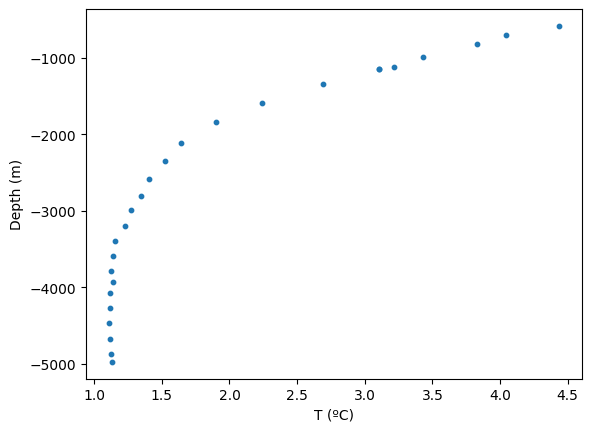

In [2]:
import matplotlib.pyplot as plt

# Temperature measurements extracted from Figure 3 in Munk, 1966
CTD_T = [1.1296296296296295, 1.122004357298475, 1.1143790849673203, 1.1067538126361656, 1.1143790849673203, 1.1143790849673203, 1.1372549019607843, 1.122004357298475, 1.1372549019607843, 1.1525054466230937, 1.2287581699346406, 1.2745098039215685, 1.343137254901961, 1.4041394335511983, 1.526143790849673, 1.6405228758169934, 1.8997821350762527, 2.242919389978214, 2.69281045751634, 3.104575163398693, 3.104575163398693, 3.218954248366013, 3.4324618736383443, 3.8289760348583877, 4.042483660130719, 4.438997821350762]
CTD_z = [-4976.958525345623, -4869.431643625192, -4677.419354838709, -4470.046082949309, -4270.353302611367, -4070.6605222734256, -3932.411674347158, -3786.4823348694317, -3586.78955453149, -3394.7772657450078, -3195.084485407066, -2995.3917050691243, -2803.379416282642, -2580.6451612903224, -2350.230414746544, -2112.1351766513058, -1843.3179723502303, -1597.5422427035332, -1344.0860215053763, -1144.3932411674346, -1144.3932411674346, -1121.351766513057, -990.7834101382491, -821.8125960061443, -698.9247311827958, -583.7173579109067]

plt.scatter(CTD_T,CTD_z,s=10)
plt.xlabel('T (ºC)')
plt.ylabel('Depth (m)')


### 1.2 Abyssal recipes

Munk (1966) proposed that the thermal structure of the ocean interior is set by a balance between upwelling and diffusion. In this view, cold waters sink near the poles and spread across the seafloor before slowly rising through the ocean interior. If we assume, as Munk did, that the water upwells uniformly across the globe, the upwelling speed is approximately $10^{-7}$ m/s. This is far too small to directly measure, but it is large enough to have a major impact on the distribution of tracers. Since light can only penetrate through the top ~100m of ocean, we can ignore solar heating, except in that it sets the temperature near the ocean surface.

### 1.3 Steady advection/diffusion equation

Dedalus can solve differential equations in various forms. In addition to time-dependent initial value problems (IVPs), Dedalus can solve linear and nonlinear boundary value problems. The code below uses Dedalus to solve a linear boundary value problem (IVBP) for the steady state advection/diffusion equation.

Here, the top and bottom temperature are set from the measured profile and these are used as boundary conditions. The vertical (upwelling) velocity is set to $10^{-7} m/s$, and the diffusivity is set to $10^{-7}$ $m^2/s$, to approximate the molecular diffusivity of heat in seawater.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s


2024-12-17 15:59:55,910 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s


Text(0, 0.5, 'Depth (m)')

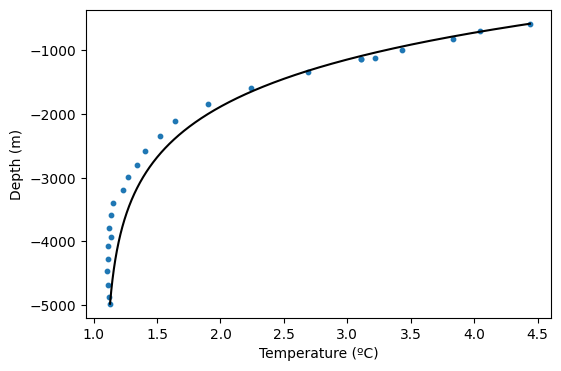

In [64]:
"""
Dedalus script to solve the steady advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the upwelling velocity
w = 1e-7 # m/s
# Set the diffusivity
kappa=1e-4 # m^2/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - kappa*Tzz = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

### 1.4 Student investigation
<a id='section1pt4'></a>
Note that the profile above is not a good fit to the data. This implies that molecular diffusion isn't sufficient to transport heat down from the surface and stop the ocean from filling up with cold, dense water.

Munk (1966) proposed that small-scale turbulence in the ocean interior results in a diffusivity that is orders of magnitude larger than the molecular value. Find a diffusivity that gives a good match with the data and test it in the Dedalus script above. Comment on the ability of this model (steady advection/diffusion) to fit the data.

ADD DISCUSSION HERE

The original diffusivity $\kappa = 10^{-7}\, \mathrm{m}^2\mathrm{s}^{-1}$ yields a model that is not a good fit to the data. We test diffusivities of increasing orders of magnitude to find that $\kappa \sim 10^{-4}\, \mathrm{m}^2\mathrm{s}^{-1}$ gives a good match to the data. By testing higher orders of magnitude we find the rate of heat transport by diffusion from the surface to the deep ocean dominates over upwelling, approaching a linear model of decreasing heat with increasing depth. The optimal order of magnitude of $\kappa \sim 10^{-4}\, \mathrm{m}^2\mathrm{s}^{-1}$ is observed to provide a good balance between diffusion of heat down from the surface and upwelling, providing a good fit to the data.

### 1.5 Turning ocean mixing upside down

Decades of research to measure the turbulent diffusivity in the ocean consistently found values much smaller than the one predicted by Munk (1966). Specifically, while larger values of the turbulent diffusivity were found near the bottom of the ocean over rough topographic features, the values in the upper ocean were about 10x smaller than the values predicted by Munk. 50 years after Munk's seminal paper, Ferrari et al. (2016) proposed that a depth-dependent turbulent diffusivity could be balanced by <em>downwelling</em>, with negative vertical velocities in the ocean interior. In this theory, the overturning circulation is upwelling in thin boundary layers along the sloping sides of the ocean basins.

When the diffusivity, $\kappa$, is a function of $z$, the steady advection/diffusion equation can be written

$$ w\frac{dT}{dz} = \frac{d}{dz}\left(\kappa(z) \frac{dT}{dz}\right)$$

The Dedalus script below solves the previous equation and again compares the results with the observed temperature profile. For the depth-dependent diffusivity, $\kappa(z)$, we take

$$ \kappa(z)=\kappa_{bg} + (\kappa_0-\kappa_{bg})e^{-(z+D)/l} $$

using the form from Rogers et al., 2023, where $\kappa_{bg}=1\times 10^{-5} m^2/s$ is the background diffusivity characteristic of the upper water column, $\kappa_0=8.6\times 10^{-4} m^2/s$ characterizes the enhanced mixing near the bottom of the ocean, $D$ is a reference depth where $\kappa=\kappa_0$, and $l=667m$ is an exponential decay scale. In the script below, we start with $w=0$.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.3e+00/s


2024-12-17 13:19:11,706 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.3e+00/s


Text(0, 0.5, 'Depth (m)')

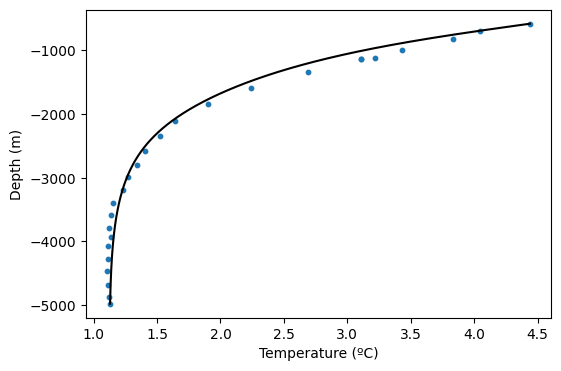

In [41]:
"""
Dedalus script to solve the steady advection/diffusion equation
with a spatially-variable diffusivity
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the vertical velocity
w = 1e-8 # m/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)
kappa = dist.Field(name='kappa', bases=zbasis)
# Set the diffusivity
# Below is the diffusivity profile from Rogers et al., 2023
kappa['g']=1e-5 + (8.6e-4-1e-5)*np.exp((-5e3-z)/667) # m^2/s

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

### 1.6 Student investigation
<a id='section1pt6'></a>
Note from the results of the script above that the density profile is reasonable, even though $w=0$. In the box below, comment on the balance in this case and what this implies about the diffusive heat flux.

Next, find a vertical velocity that produces a better agreement with the observations and report it below. Then, try varying the details of the $\kappa(z)$ profile. How sensitive is the optimal $w$ to your choice of $\kappa(z)$? What does this imply about the circulation in the ocean interior if $\kappa(z)$ varies between regions of smooth and rough topography?

(As an aside, note that the requied vertical velocity is much smaller than the one used by Munk (1966). This implies that the dense, cold water that sinks at the poles must rise elsewhere. Ferrari et al. (2016) proposed that this occurs in boundary layers near the seafloor.)

INSERT COMMENTS HERE

For the case $w = 0$, the model shows a good match with the data. Therefore, we see that diffusive transort alone (without advection) provides a reasonably good model for heat transport in the ocean assuming the variable diffusivity given above. With $w=0$, the advection-diffusion equation simplifies to
$$ 0 = \frac{d}{dz}\left(\kappa(z) \frac{dT}{dz}\right)\, ,$$
and hence the diffusive heat flux, $-\kappa(z) \frac{dT}{dz}$ is constant with depth.

By testing different orders of magnitude for $w$, we find $w \sim 10^{-8}\ \mathrm{m}\mathrm{s}^{-2}$ produces a better agreement with the observations.

The original $\kappa(z)$ profile is given by
$$ \kappa(z)=\kappa_{bg} + (\kappa_0-\kappa_{bg})e^{-(z+D)/l}\, , $$
where $\kappa_{bg}=1\times 10^{-5} m^2/s$, $\kappa_0=8.6\times 10^{-4} m^2/s$, $D=-5000 m$ and $l=667m$.

We investigate the effect on the optimal value for $w$ by varying the profile $\kappa(z)$. For a particular value for $w$ and profile for $\kappa(z)$, the following function RMSE(w_val,kappa_bg,kappa_0,D,l) calculates the root mean square error (RMSE) of the model against the observed data. We use this function to optimise over $w$ to find the optimal value for which the RMSE is minimised. In particular, we are interested in the sensitivity of the optimal $w$ to changes in $\kappa_0$ (since changes in $\kappa_0$ reflect variations in the smoothenss of the ocean floor topography). The figure below shows that the optimal $w$ is very sensitive to the value of $\kappa_0$, with downwelling in regions of rough topography ($\kappa_0 \gtrapprox  10^{-3}$) and upwelling in regions of smooth topography ($\kappa_0 \lessapprox  10^{-3}$).

In [62]:
# The following code block defines a function for computing the RMSE between the model and the observations for varying w and the parameters in kappa(z)

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

def RMSE(w_val,kappa_bg,kappa_0,D,l):
    # Set various parameters. Note that the depth and the top and bottom temperature
    # are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
    z_surface = CTD_z[-1]
    z_bottom = CTD_z[0]
    T_surface = CTD_T[-1]
    T_bottom = CTD_T[0]
    Nz = 1000

    # Set the vertical velocity
    w = w_val[0] # m/s

    # Bases
    zcoord = d3.Coordinate('z')
    dist = d3.Distributor(zcoord, dtype=np.float64)
    zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
    z = dist.local_grid(zbasis)

    # Fields
    T = dist.Field(name='T', bases=zbasis)
    kappa = dist.Field(name='kappa', bases=zbasis)
    # Set the diffusivity
    # Below is the diffusivity profile from Rogers et al., 2023
    kappa['g']=kappa_bg + (kappa_0-kappa_bg)*np.exp((D-z)/l) # m^2/s

    # Add two tau variables to allow us to apply two boundary conditions
    tau_1 = dist.Field(name='tau_1')
    tau_2 = dist.Field(name='tau_2')
    lift_basis = zbasis.derivative_basis(1)
    lift = lambda A: d3.Lift(A, lift_basis, -1)

    # Substitutions
    dz = lambda A: d3.Differentiate(A, zcoord)
    Tz = dz(T) + lift(tau_1)
    Tzz = dz(Tz) + lift(tau_2)

    # Problem
    problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
    problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
    problem.add_equation("T(z=z_surface) = T_surface")
    problem.add_equation("T(z=z_bottom) = T_bottom")

    # Solver
    solver = problem.build_solver()
    solver.solve()

    # Solution
    Tg = T['g']
    Tg_sample = np.array([Tg[np.abs(z-depth).argmin()] for depth in CTD_z])

    # Calculate RMSE
    return np.sqrt(np.mean((Tg_sample-CTD_T)**2))

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.4e+00/s


2024-12-17 15:54:56,999 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.4e+00/s


2024-12-17 15:54:57,746 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s


2024-12-17 15:54:58,339 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-17 15:54:58,836 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.3e+00/s


2024-12-17 15:54:59,612 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.4e+00/s


2024-12-17 15:55:00,379 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.9e+00/s


2024-12-17 15:55:00,937 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s


2024-12-17 15:55:01,464 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:55:01,950 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-17 15:55:02,456 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-17 15:55:02,970 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.9e+00/s


2024-12-17 15:55:03,527 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-17 15:55:04,020 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:55:04,499 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-17 15:55:04,995 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:55:05,479 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:55:05,967 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-17 15:55:06,486 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


2024-12-17 15:55:07,141 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s


2024-12-17 15:55:07,749 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 6.1e-01/s


2024-12-17 15:55:09,418 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 6.1e-01/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


2024-12-17 15:55:10,229 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.4e+00/s


2024-12-17 15:55:10,969 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.3e+00/s


2024-12-17 15:55:11,763 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.9e+00/s


2024-12-17 15:55:12,326 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:55:12,801 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-17 15:55:13,310 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:55:13,792 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:55:14,276 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:55:14,770 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:55:15,261 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:55:15,743 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-17 15:55:16,241 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-17 15:55:16,734 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s


2024-12-17 15:55:17,261 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:55:17,775 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-17 15:55:18,271 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:55:18,758 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-17 15:55:19,258 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-17 15:55:19,761 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:55:20,252 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:55:20,733 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:55:21,217 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:55:21,686 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s


2024-12-17 15:55:22,312 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


2024-12-17 15:55:22,996 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


2024-12-17 15:55:23,670 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.4e+00/s


2024-12-17 15:55:24,431 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


2024-12-17 15:55:25,148 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


2024-12-17 15:55:25,844 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:55:26,344 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:55:26,803 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-17 15:55:27,311 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:55:27,766 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:55:28,253 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:55:28,707 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:55:29,187 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:55:29,660 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:55:30,152 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:55:30,616 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:55:31,082 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:55:31,560 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:55:32,031 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:55:32,520 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:55:32,981 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:55:33,469 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:55:33,931 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:55:34,419 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:55:34,863 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:55:35,352 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:55:35,823 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.4e+00/s


2024-12-17 15:55:36,571 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


2024-12-17 15:55:37,286 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


2024-12-17 15:55:38,012 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.4e+00/s


2024-12-17 15:55:38,758 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


2024-12-17 15:55:39,472 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s


2024-12-17 15:55:40,061 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:55:40,549 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:55:41,034 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:55:41,518 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-17 15:55:42,031 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:55:42,519 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s


2024-12-17 15:55:43,042 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-17 15:55:43,541 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s


2024-12-17 15:55:44,069 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:55:44,553 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-17 15:55:45,057 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:55:45,554 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-17 15:55:46,057 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 4.3e-01/s


2024-12-17 15:55:48,385 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 4.3e-01/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-17 15:55:48,886 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-17 15:55:49,385 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s


2024-12-17 15:55:49,921 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


2024-12-17 15:55:50,637 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


2024-12-17 15:55:51,355 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


2024-12-17 15:55:52,081 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.4e+00/s


2024-12-17 15:55:52,818 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


2024-12-17 15:55:53,540 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:55:54,032 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-17 15:55:54,534 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-17 15:55:55,030 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:55:55,521 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-17 15:55:56,037 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-17 15:55:56,551 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:55:57,039 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-17 15:55:57,534 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:55:58,023 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-17 15:55:58,527 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:55:59,016 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s


2024-12-17 15:55:59,533 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:56:00,022 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s


2024-12-17 15:56:00,633 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s


2024-12-17 15:56:01,167 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-17 15:56:01,677 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:56:02,128 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:56:02,596 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:56:03,039 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:56:03,525 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s


2024-12-17 15:56:04,171 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s


2024-12-17 15:56:04,814 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s


2024-12-17 15:56:05,456 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


2024-12-17 15:56:06,127 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


2024-12-17 15:56:06,841 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:56:07,327 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:56:07,777 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:56:08,239 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:56:08,705 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:56:09,149 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.3e+00/s


2024-12-17 15:56:09,964 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s


2024-12-17 15:56:10,633 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:56:11,092 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:56:11,537 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:56:11,984 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:56:12,426 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:56:12,870 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:56:13,309 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:56:13,755 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:56:14,219 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s


2024-12-17 15:56:14,651 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:56:15,094 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:56:15,540 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:56:15,988 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:56:16,428 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:56:16,885 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


2024-12-17 15:56:17,529 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s


2024-12-17 15:56:18,134 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s


2024-12-17 15:56:18,713 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


2024-12-17 15:56:19,385 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


2024-12-17 15:56:20,034 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


2024-12-17 15:56:20,698 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:56:21,161 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s


2024-12-17 15:56:21,604 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:56:22,047 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:56:22,494 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:56:22,933 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s


2024-12-17 15:56:23,369 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s


2024-12-17 15:56:23,797 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:56:24,273 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:56:24,728 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:56:25,182 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:56:25,652 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:56:26,145 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:56:26,613 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s


2024-12-17 15:56:27,051 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:56:27,506 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:56:27,947 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:56:28,398 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:56:28,846 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:56:29,299 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s


2024-12-17 15:56:29,735 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s


2024-12-17 15:56:30,169 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:56:30,631 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s


2024-12-17 15:56:31,233 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s


2024-12-17 15:56:31,849 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s


2024-12-17 15:56:32,466 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


2024-12-17 15:56:33,138 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


2024-12-17 15:56:33,811 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


2024-12-17 15:56:34,508 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:56:34,993 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:56:35,447 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:56:35,890 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:56:36,369 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:56:36,827 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:56:37,289 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:56:37,747 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:56:38,235 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:56:38,699 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:56:39,161 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:56:39,626 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:56:40,108 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:56:40,571 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:56:41,048 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:56:41,522 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:56:41,984 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:56:42,445 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:56:42,890 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:56:43,375 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:56:43,818 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:56:44,308 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s


2024-12-17 15:56:44,886 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s


2024-12-17 15:56:45,526 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s


2024-12-17 15:56:46,147 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


2024-12-17 15:56:46,817 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


2024-12-17 15:56:47,510 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


2024-12-17 15:56:48,204 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:56:48,657 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:56:49,121 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:56:49,599 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:56:50,058 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:56:50,515 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:56:50,969 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:56:51,430 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:56:51,874 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:56:52,332 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:56:52,794 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:56:53,254 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:56:53,727 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:56:54,180 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:56:54,646 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:56:55,113 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:56:55,568 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:56:56,025 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:56:56,508 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:56:56,978 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 5.1e-01/s


2024-12-17 15:56:58,956 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 5.1e-01/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s


2024-12-17 15:56:59,589 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


2024-12-17 15:57:00,303 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.4e+00/s


2024-12-17 15:57:01,064 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


2024-12-17 15:57:01,727 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s


2024-12-17 15:57:02,308 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s


2024-12-17 15:57:02,739 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:57:03,204 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:57:03,665 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:57:04,133 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:57:04,580 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:57:05,058 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:57:05,512 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:57:05,956 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:57:06,424 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s


2024-12-17 15:57:06,868 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:57:07,335 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:57:07,779 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:57:08,240 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:57:08,684 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:57:09,139 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:57:09,594 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:57:10,033 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:57:10,484 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:57:10,927 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:57:11,400 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:57:11,842 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s


2024-12-17 15:57:12,420 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s


2024-12-17 15:57:13,062 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s


2024-12-17 15:57:13,689 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


2024-12-17 15:57:14,386 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


2024-12-17 15:57:15,053 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


2024-12-17 15:57:15,724 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-17 15:57:16,237 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:57:16,694 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:57:17,136 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:57:17,590 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:57:18,039 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:57:18,502 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:57:18,955 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:57:19,425 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:57:19,893 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:57:20,341 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:57:20,795 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:57:21,249 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:57:21,703 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:57:22,068 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:57:22,441 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:57:22,813 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:57:23,193 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:57:23,561 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:57:23,927 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:57:24,304 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:57:24,678 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:57:25,053 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:57:25,415 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:57:25,777 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s


2024-12-17 15:57:26,310 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-17 15:57:26,815 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-17 15:57:27,323 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:57:27,811 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s


2024-12-17 15:57:28,362 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s


2024-12-17 15:57:28,902 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s


2024-12-17 15:57:29,438 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:57:29,900 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:57:30,282 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:57:30,656 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:57:31,035 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:57:31,405 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:57:31,755 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s


2024-12-17 15:57:32,157 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:57:32,508 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


2024-12-17 15:57:32,851 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:57:33,228 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:57:33,580 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:57:33,946 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:57:34,314 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


2024-12-17 15:57:34,669 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:57:35,024 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s


2024-12-17 15:57:35,411 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:57:35,763 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s


2024-12-17 15:57:36,150 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:57:36,538 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:57:36,895 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s


2024-12-17 15:57:37,307 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:57:37,661 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:57:38,028 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:57:38,403 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:57:38,771 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:57:39,155 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s


2024-12-17 15:57:39,542 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:57:40,030 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s


2024-12-17 15:57:40,567 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:57:41,059 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.4e+00/s


2024-12-17 15:57:41,795 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.0e+00/s


2024-12-17 15:57:42,807 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.4e+00/s


2024-12-17 15:57:43,613 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s


2024-12-17 15:57:44,040 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:57:44,413 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:57:44,776 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:57:45,155 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:57:45,514 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:57:45,871 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:57:46,248 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:57:46,607 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:57:46,982 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:57:47,344 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s


2024-12-17 15:57:47,734 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:57:48,086 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:57:48,458 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:57:48,825 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:57:49,199 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:57:49,555 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:57:49,919 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:57:50,293 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:57:50,648 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:57:51,011 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:57:51,370 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


2024-12-17 15:57:51,717 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:57:52,086 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:57:52,442 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


2024-12-17 15:57:52,785 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:57:53,157 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:57:53,538 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:57:53,989 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s


2024-12-17 15:57:54,524 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s


2024-12-17 15:57:55,053 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:57:55,544 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 4.9e-01/s


2024-12-17 15:57:57,640 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 4.9e-01/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:57:57,998 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s


2024-12-17 15:57:58,380 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:57:58,737 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:57:59,103 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s


2024-12-17 15:57:59,502 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:57:59,862 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s


2024-12-17 15:58:00,264 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s


2024-12-17 15:58:00,661 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:58:01,036 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s


2024-12-17 15:58:01,419 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:58:01,780 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:58:02,137 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:58:02,512 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:58:02,864 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:58:03,241 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:58:03,616 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:58:03,977 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:58:04,362 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


2024-12-17 15:58:04,708 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:58:05,087 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:58:05,459 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:58:05,815 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:58:06,184 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:58:06,561 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:58:06,922 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s


2024-12-17 15:58:07,313 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:58:07,762 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s


2024-12-17 15:58:08,310 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-17 15:58:08,826 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:58:09,334 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s


2024-12-17 15:58:09,895 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s


2024-12-17 15:58:10,450 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s


2024-12-17 15:58:10,998 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s


2024-12-17 15:58:11,429 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:58:11,793 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:58:12,159 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:58:12,533 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:58:12,909 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:58:13,276 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:58:13,641 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s


2024-12-17 15:58:14,028 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:58:14,407 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:58:14,781 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:58:15,158 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:58:15,535 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s


2024-12-17 15:58:15,923 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s


2024-12-17 15:58:16,311 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:58:16,671 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s


2024-12-17 15:58:17,058 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:58:17,427 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:58:17,793 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s


2024-12-17 15:58:18,192 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:58:18,559 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:58:18,941 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:58:19,317 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:58:19,680 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:58:20,045 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:58:20,417 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:58:20,771 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:58:21,144 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-17 15:58:21,654 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-17 15:58:22,172 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:58:22,682 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.9e+00/s


2024-12-17 15:58:23,243 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-17 15:58:23,780 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.9e+00/s


2024-12-17 15:58:24,351 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-17 15:58:24,867 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:58:25,235 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


2024-12-17 15:58:25,581 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:58:25,944 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s


2024-12-17 15:58:26,351 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:58:26,734 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:58:27,095 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:58:27,465 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:58:27,821 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:58:28,192 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:58:28,554 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:58:28,913 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:58:29,276 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:58:29,656 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:58:30,015 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:58:30,392 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


2024-12-17 15:58:30,740 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:58:31,100 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:58:31,464 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:58:31,821 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:58:32,184 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:58:32,546 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:58:32,895 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:58:33,249 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:58:33,607 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


2024-12-17 15:58:33,952 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:58:34,321 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:58:34,678 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:58:35,141 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:58:35,652 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:58:36,157 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s


2024-12-17 15:58:36,711 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-17 15:58:37,240 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s


2024-12-17 15:58:37,774 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s


2024-12-17 15:58:38,323 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s


2024-12-17 15:58:38,747 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:58:39,107 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:58:39,484 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:58:39,865 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:58:40,237 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:58:40,598 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:58:40,971 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:58:41,341 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


2024-12-17 15:58:41,687 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:58:42,070 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:58:42,429 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


2024-12-17 15:58:42,780 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:58:43,146 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:58:43,501 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


2024-12-17 15:58:43,849 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:58:44,230 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:58:44,580 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:58:44,943 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:58:45,311 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


2024-12-17 15:58:45,655 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:58:46,029 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:58:46,391 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:58:46,764 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:58:47,143 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:58:47,506 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


2024-12-17 15:58:47,854 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-17 15:58:48,237 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s


2024-12-17 15:58:48,653 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s


2024-12-17 15:58:49,192 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:58:49,695 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s


2024-12-17 15:58:50,132 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-17 15:58:50,655 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.1e+00/s


2024-12-17 15:58:51,670 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 9.8e-01/s


2024-12-17 15:58:52,741 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 9.8e-01/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:58:53,129 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s


2024-12-17 15:58:53,462 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


2024-12-17 15:58:53,783 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


2024-12-17 15:58:54,105 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s


2024-12-17 15:58:54,448 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


2024-12-17 15:58:54,768 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s


2024-12-17 15:58:55,108 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 6.0e-01/s


2024-12-17 15:58:56,811 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 6.0e-01/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


2024-12-17 15:58:57,128 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:58:57,488 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


2024-12-17 15:58:57,806 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


2024-12-17 15:58:58,133 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s


2024-12-17 15:58:58,462 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


2024-12-17 15:58:58,791 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s


2024-12-17 15:58:59,128 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s


2024-12-17 15:58:59,464 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:58:59,815 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:59:00,174 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:59:00,542 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:59:00,903 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s


2024-12-17 15:59:01,242 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


2024-12-17 15:59:01,560 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


2024-12-17 15:59:01,903 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


2024-12-17 15:59:02,227 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


2024-12-17 15:59:02,546 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


2024-12-17 15:59:02,876 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:59:03,362 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:59:03,834 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:59:04,288 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s


2024-12-17 15:59:04,717 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-17 15:59:05,251 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:59:05,753 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-17 15:59:06,265 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:59:06,756 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s


2024-12-17 15:59:07,168 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


2024-12-17 15:59:07,502 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


2024-12-17 15:59:07,829 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s


2024-12-17 15:59:08,166 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


2024-12-17 15:59:08,502 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


2024-12-17 15:59:08,823 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


2024-12-17 15:59:09,175 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s


2024-12-17 15:59:09,516 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


2024-12-17 15:59:09,839 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:59:10,197 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


2024-12-17 15:59:10,529 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


2024-12-17 15:59:10,855 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:59:11,207 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


2024-12-17 15:59:11,529 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


2024-12-17 15:59:11,854 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:59:12,223 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


2024-12-17 15:59:12,550 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


2024-12-17 15:59:12,869 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


2024-12-17 15:59:13,214 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s


2024-12-17 15:59:13,552 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


2024-12-17 15:59:13,874 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


2024-12-17 15:59:14,223 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


2024-12-17 15:59:14,552 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


2024-12-17 15:59:14,873 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:59:15,228 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


2024-12-17 15:59:15,545 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s


2024-12-17 15:59:15,886 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:59:16,246 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


2024-12-17 15:59:16,567 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


2024-12-17 15:59:16,887 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:59:17,384 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s


2024-12-17 15:59:17,827 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:59:18,284 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s


2024-12-17 15:59:18,713 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:59:19,219 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:59:19,716 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:59:20,197 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-17 15:59:20,685 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-17 15:59:21,050 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s


2024-12-17 15:59:21,385 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


2024-12-17 15:59:21,712 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


2024-12-17 15:59:22,036 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


2024-12-17 15:59:22,362 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


2024-12-17 15:59:22,692 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


2024-12-17 15:59:23,013 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


2024-12-17 15:59:23,344 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


2024-12-17 15:59:23,696 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


2024-12-17 15:59:24,025 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


2024-12-17 15:59:24,351 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


2024-12-17 15:59:24,680 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s


2024-12-17 15:59:25,015 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


2024-12-17 15:59:25,342 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


2024-12-17 15:59:25,665 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


2024-12-17 15:59:25,990 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


2024-12-17 15:59:26,313 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


2024-12-17 15:59:26,636 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:59:26,994 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s


2024-12-17 15:59:27,336 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


2024-12-17 15:59:27,655 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s


2024-12-17 15:59:27,987 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


2024-12-17 15:59:28,316 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.7e+00/s


2024-12-17 15:59:28,621 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s


2024-12-17 15:59:28,954 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


2024-12-17 15:59:29,282 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s


2024-12-17 15:59:29,625 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


2024-12-17 15:59:29,970 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


2024-12-17 15:59:30,301 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


2024-12-17 15:59:30,619 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s


2024-12-17 15:59:31,037 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-17 15:59:31,522 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.3e+00/s


2024-12-17 15:59:32,329 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 7.4e-01/s


2024-12-17 15:59:33,756 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 7.4e-01/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s


2024-12-17 15:59:34,357 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.9e+00/s


2024-12-17 15:59:34,924 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-17 15:59:35,298 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-17 15:59:35,748 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.3e+00/s


2024-12-17 15:59:36,585 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.4e+00/s


2024-12-17 15:59:37,395 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+00/s


2024-12-17 15:59:37,706 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


2024-12-17 15:59:38,033 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 9.2e+00/s


2024-12-17 15:59:38,176 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 9.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.4e+00/s


2024-12-17 15:59:38,347 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.6e+00/s


2024-12-17 15:59:38,499 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.6e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.4e+00/s


2024-12-17 15:59:38,651 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.7e+00/s


2024-12-17 15:59:38,797 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.3e+00/s


2024-12-17 15:59:38,955 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.3e+00/s


2024-12-17 15:59:39,112 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.7e+00/s


2024-12-17 15:59:39,294 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.7e+00/s


2024-12-17 15:59:39,442 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.4e+00/s


2024-12-17 15:59:39,595 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 9.0e+00/s


2024-12-17 15:59:39,738 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 9.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.8e+00/s


2024-12-17 15:59:39,899 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.8e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.5e+00/s


2024-12-17 15:59:40,048 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.7e+00/s


2024-12-17 15:59:40,212 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.1e+00/s


2024-12-17 15:59:40,389 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.7e+00/s


2024-12-17 15:59:40,538 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.8e+00/s


2024-12-17 15:59:40,683 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.8e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 6.6e-01/s


2024-12-17 15:59:42,225 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 6.6e-01/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.7e+00/s


2024-12-17 15:59:42,386 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.5e+00/s


2024-12-17 15:59:42,537 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.3e+00/s


2024-12-17 15:59:42,691 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.8e+00/s


2024-12-17 15:59:42,851 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.8e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.3e+00/s


2024-12-17 15:59:43,005 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.8e+00/s


2024-12-17 15:59:43,153 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.8e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.9e+00/s


2024-12-17 15:59:43,318 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.3e+00/s


2024-12-17 15:59:43,488 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.6e+00/s


2024-12-17 15:59:43,638 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.6e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.7e+00/s


2024-12-17 15:59:43,788 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.7e+00/s


2024-12-17 15:59:43,939 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.7e+00/s


2024-12-17 15:59:44,103 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.8e+00/s


2024-12-17 15:59:44,266 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.8e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.9e+00/s


2024-12-17 15:59:44,426 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.6e+00/s


2024-12-17 15:59:44,580 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.6e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.5e+00/s


2024-12-17 15:59:44,730 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.1e+00/s


2024-12-17 15:59:44,885 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.5e+00/s


2024-12-17 15:59:45,039 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-12-17 15:59:45,294 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.3e+00/s


2024-12-17 15:59:45,563 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.0e+00/s


2024-12-17 15:59:45,803 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.4e+00/s


2024-12-17 15:59:46,035 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.3e+00/s


2024-12-17 15:59:46,259 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.6e+00/s


2024-12-17 15:59:46,473 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.6e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.4e+00/s


2024-12-17 15:59:46,699 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.3e+00/s


2024-12-17 15:59:46,939 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.1e+00/s


2024-12-17 15:59:47,168 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.0e+00/s


2024-12-17 15:59:47,427 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.1e+00/s


2024-12-17 15:59:47,664 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.2e+00/s


2024-12-17 15:59:47,905 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.1e+00/s


2024-12-17 15:59:48,136 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.7e+00/s


2024-12-17 15:59:48,384 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.4e+00/s


2024-12-17 15:59:48,603 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.0e+00/s


2024-12-17 15:59:48,841 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-12-17 15:59:49,087 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.3e+00/s


2024-12-17 15:59:49,259 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.2e+00/s


2024-12-17 15:59:49,414 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.5e+00/s


2024-12-17 15:59:49,566 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.2e+00/s


2024-12-17 15:59:49,740 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.2e+00/s


2024-12-17 15:59:49,897 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.2e+00/s


2024-12-17 15:59:50,052 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.8e+00/s


2024-12-17 15:59:50,218 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.8e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.0e+00/s


2024-12-17 15:59:50,383 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.7e+00/s


2024-12-17 15:59:50,535 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.7e+00/s


2024-12-17 15:59:50,700 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.6e+00/s


2024-12-17 15:59:50,868 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.6e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.7e+00/s


2024-12-17 15:59:51,030 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.3e+00/s


2024-12-17 15:59:51,200 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.4e+00/s


2024-12-17 15:59:51,382 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.4e+00/s


2024-12-17 15:59:51,534 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.2e+00/s


2024-12-17 15:59:51,692 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.8e+00/s


2024-12-17 15:59:51,855 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.8e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.9e+00/s


2024-12-17 15:59:52,015 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.5e+00/s


2024-12-17 15:59:52,170 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.5e+00/s


2024-12-17 15:59:52,340 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.4e+00/s


2024-12-17 15:59:52,491 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.4e+00/s


2024-12-17 15:59:52,644 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.7e+00/s


2024-12-17 15:59:52,791 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.0e+00/s


2024-12-17 15:59:52,968 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.6e+00/s


2024-12-17 15:59:53,119 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.6e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.2e+00/s


2024-12-17 15:59:53,297 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.2e+00/s


2024-12-17 15:59:53,452 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.4e+00/s


2024-12-17 15:59:53,604 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.5e+00/s


2024-12-17 15:59:53,757 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.4e+00/s


2024-12-17 15:59:53,924 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.2e+00/s


2024-12-17 15:59:54,081 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.7e+00/s


2024-12-17 15:59:54,250 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.0e+00/s


2024-12-17 15:59:54,411 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.4e+00/s


2024-12-17 15:59:54,565 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.3e+00/s


2024-12-17 15:59:54,721 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.5e+00/s


2024-12-17 15:59:54,873 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.5e+00/s


2024-12-17 15:59:55,056 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.8e+00/s


2024-12-17 15:59:55,225 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.8e+00/s


Text(0, 0.5, 'Optimal $w\\ (\\mathrm{m/s})$')

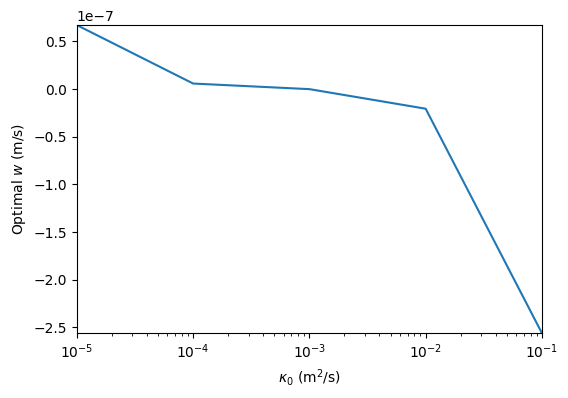

In [63]:
# Produces a figure of how the optimal w value varies with kappa_0

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)
from scipy.optimize import minimize

kappa_0_values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
kappa_bg = 1e-5
D = -5000
l = 667

w_opt = np.zeros(len(kappa_0_values))
for i, kappa_0 in enumerate(kappa_0_values):
  # Initial guess for w
  w_initial = 0

  # Find optimal w
  result = minimize(RMSE, w_initial, args=(kappa_bg, kappa_0, D, l))
  w_opt[i] = result.x[0]

# Plot
plt.figure(figsize=(6, 4))
plt.plot(kappa_0_values,w_opt)
plt.xscale('log')
plt.xlim(min(kappa_0_values),max(kappa_0_values))
plt.ylim(min(w_opt),max(w_opt))
plt.xlabel('$\kappa_0\ (\mathrm{m^2/s})$')
plt.ylabel('Optimal $w\ (\mathrm{m/s})$')




## 2. Transport of pollution in a river

Advection/diffusion equations are a common way to model the material transport in many physical systems. In this section we will model the transport and dilution of a pollutants added to a river.

For simplicity, we will model the river as a rectangular channel, and we will neglect depth variations. Let $x$ be the coordinate along the length of the river, and $y$ be the cross-stream coordinate. We will model the river current as

$$ u(y) = U_0\left(1-\frac{(y-w/2)^2}{(w/2)^2}\right) $$

where $w$ is the width of the river and $U_0$ is the maximum current speed which occurs at the center of the river (the $y$-coordinate will run from 0 to $w$).

Since we want to know how the pollution levels vary in time, we will solve the time-dependent advection/diffusion equation. We will model the addition of pollution by adding a spatially-dependent source term to the right hand side of the equation governing pollutant concentration:

$$ \frac{\partial c}{\partial t} + u(y)\frac{\partial c}{\partial x} = \kappa \nabla^2 c + S(x,y) $$

where $\nabla^2=(\partial_x^2 + \partial_y^2)$ is the Laplacian operator for diffusion in 2D Cartesian coordinates, and $S$ is the source term.

### 2.1 Dedalus script

The script below solves the time-dependent advection/diffusion equation with a source term.

In [81]:
"""
Script to solve the time-dependent advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Set parameters
U0 = 0.1 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='b', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.9e+00/s


2024-12-17 16:50:36,229 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.9e+00/s


INFO:__main__:Starting main loop


2024-12-17 16:50:36,238 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2024-12-17 16:50:36,278 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2024-12-17 16:50:36,312 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2024-12-17 16:50:36,344 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2024-12-17 16:50:36,385 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2024-12-17 16:50:36,420 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2024-12-17 16:50:36,453 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2024-12-17 16:50:36,486 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2024-12-17 16:50:36,523 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2024-12-17 16:50:36,559 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2024-12-17 16:50:36,591 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2024-12-17 16:50:36,626 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2024-12-17 16:50:36,660 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2024-12-17 16:50:36,692 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2024-12-17 16:50:36,724 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2024-12-17 16:50:36,756 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2024-12-17 16:50:36,787 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2024-12-17 16:50:36,820 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2024-12-17 16:50:36,851 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2024-12-17 16:50:36,883 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2024-12-17 16:50:36,916 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2024-12-17 16:50:36,950 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2024-12-17 16:50:36,982 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2024-12-17 16:50:37,016 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2024-12-17 16:50:37,055 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2024-12-17 16:50:37,089 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2024-12-17 16:50:37,129 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2024-12-17 16:50:37,163 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2024-12-17 16:50:37,199 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2024-12-17 16:50:37,239 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2024-12-17 16:50:37,277 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2024-12-17 16:50:37,331 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2024-12-17 16:50:37,382 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2024-12-17 16:50:37,453 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2024-12-17 16:50:37,516 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2024-12-17 16:50:37,567 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2024-12-17 16:50:37,623 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2024-12-17 16:50:37,682 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2024-12-17 16:50:37,733 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2024-12-17 16:50:37,794 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2024-12-17 16:50:37,852 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2024-12-17 16:50:37,908 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2024-12-17 16:50:37,959 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2024-12-17 16:50:38,010 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2024-12-17 16:50:38,055 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2024-12-17 16:50:38,109 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2024-12-17 16:50:38,162 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2024-12-17 16:50:38,211 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2024-12-17 16:50:38,257 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2024-12-17 16:50:38,320 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2024-12-17 16:50:38,374 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2024-12-17 16:50:38,426 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2024-12-17 16:50:38,477 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2024-12-17 16:50:38,541 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2024-12-17 16:50:38,594 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2024-12-17 16:50:38,642 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2024-12-17 16:50:38,688 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2024-12-17 16:50:38,732 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2024-12-17 16:50:38,773 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2024-12-17 16:50:38,819 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2024-12-17 16:50:38,865 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2024-12-17 16:50:38,914 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2024-12-17 16:50:38,965 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2024-12-17 16:50:39,014 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2024-12-17 16:50:39,060 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2024-12-17 16:50:39,104 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2024-12-17 16:50:39,151 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2024-12-17 16:50:39,202 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2024-12-17 16:50:39,256 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2024-12-17 16:50:39,313 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2024-12-17 16:50:39,371 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2024-12-17 16:50:39,430 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2024-12-17 16:50:39,481 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2024-12-17 16:50:39,530 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2024-12-17 16:50:39,574 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2024-12-17 16:50:39,622 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2024-12-17 16:50:39,681 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2024-12-17 16:50:39,727 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2024-12-17 16:50:39,768 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-12-17 16:50:39,772 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-12-17 16:50:39,779 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.3056 sec


2024-12-17 16:50:39,781 solvers 0/1 INFO :: Setup time (init - iter 0): 0.3056 sec


INFO:solvers:Warmup time (iter 0-10): 0.06297 sec


2024-12-17 16:50:39,786 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.06297 sec


INFO:solvers:Run time (iter 10-end): 3.462 sec


2024-12-17 16:50:39,788 solvers 0/1 INFO :: Run time (iter 10-end): 3.462 sec


INFO:solvers:CPU time (iter 10-end): 0.0009616 cpu-hr


2024-12-17 16:50:39,793 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0009616 cpu-hr


INFO:solvers:Speed: 3.797e+06 mode-stages/cpu-sec


2024-12-17 16:50:39,806 solvers 0/1 INFO :: Speed: 3.797e+06 mode-stages/cpu-sec
(78, 256, 32)


## 2.2 Visualization

The script below makes a movie of the results from the saved variables. To run this, you need to have ffmpeg installed.  If you don't already have it installed, you can install ffmpeg with the command:

`conda install -c conda-forge ffmpeg`

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-12-17 13:58:14,027 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpn7dnaduo/temp.m4v


2024-12-17 13:58:14,033 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpn7dnaduo/temp.m4v


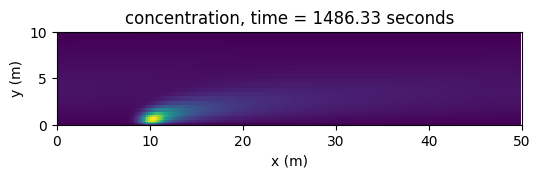

In [54]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf()
    concentration = plt.pcolor(X, Y, c_save[n,:,:].T)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlim(0, L)
    plt.ylim(0, w)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('concentration, time = {0:.2f} seconds'.format(t_save[n]))
    return (concentration,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

## 2.3 Student investigation
<a id='section2pt3'></a>
In the boxes below, plot the pollution concentration at a few points as a function of time. Then vary the maximum flow speed and the diffusivity and explore how the pollution levels depend on these parameters. Using dimensional analysis, estimate the time needed for the pollution to reach the opposite side of the river. How far downstream of the source do you expect this to happen (assuming that the domain in the x-direction is infinite).

INSERT PLOTS AND COMMENTS HERE

2024-12-17 19:09:55,722 dedalus 0/1 WARNING :: Threading has not been disabled. This may massively degrade Dedalus performance.


2024-12-17 19:09:55,739 dedalus 0/1 WARNING :: We strongly suggest setting the "OMP_NUM_THREADS" environment variable to "1".


INFO:numexpr.utils:NumExpr defaulting to 2 threads.


2024-12-17 19:09:56,272 numexpr.utils 0/1 INFO :: NumExpr defaulting to 2 threads.


DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cm

2024-12-17 19:10:00,836 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 8.5e-01/s


DEBUG:solvers:Finished IVP instantiation
INFO:__main__:Starting main loop


2024-12-17 19:10:00,884 __main__ 0/1 INFO :: Starting main loop


DEBUG:transforms:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (256, 48), 1)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 48), 0)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 1), 0)
INFO:solvers:Simulation stop time reached.


2024-12-17 19:10:01,938 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 8


2024-12-17 19:10:01,942 solvers 0/1 INFO :: Final iteration: 8


INFO:solvers:Final sim time: 1562.5


2024-12-17 19:10:01,946 solvers 0/1 INFO :: Final sim time: 1562.5


INFO:solvers:Setup time (init - iter 0): 2.431 sec


2024-12-17 19:10:01,949 solvers 0/1 INFO :: Setup time (init - iter 0): 2.431 sec


INFO:solvers:Timings unavailable because warmup did not complete.


2024-12-17 19:10:01,951 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.


DEBUG:distributor:Mesh: []
DEBUG:problems:Adding equation 0
DEBUG:problems:  LHS: C(dt(b) + u*dx(b)) + -1*0.01*Div(Grad(b) + ey*<Field 131932152391344>*tau_1) + C(<Field 131932152391344>*tau_2)
DEBUG:problems:  RHS: u
DEBUG:problems:  condition: True
DEBUG:problems:  M: C(b)
DEBUG:problems:  L: C(u*dx(b)) + -1*0.01*Div(Grad(b) + ey*<Field 131932152391344>*tau_1) + C(<Field 131932152391344>*tau_2)
DEBUG:problems:  F: C(u)
DEBUG:problems:Adding equation 1
DEBUG:problems:  LHS: interp(b, y=0)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=0)
DEBUG:problems:  F: <Field 131932154314080>
DEBUG:problems:Adding equation 2
DEBUG:problems:  LHS: interp(b, y=10)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=10)
DEBUG:problems:  F: <Field 131932152394080>
DEBUG:solvers:Beginning IVP instantiation
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class

2024-12-17 19:10:02,374 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+00/s


DEBUG:solvers:Finished IVP instantiation
INFO:__main__:Starting main loop


2024-12-17 19:10:02,384 __main__ 0/1 INFO :: Starting main loop


DEBUG:transforms:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (256, 48), 1)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 48), 0)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 1), 0)
INFO:solvers:Simulation stop time reached.


2024-12-17 19:10:02,659 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 77


2024-12-17 19:10:02,663 solvers 0/1 INFO :: Final iteration: 77


INFO:solvers:Final sim time: 1503.90625


2024-12-17 19:10:02,667 solvers 0/1 INFO :: Final sim time: 1503.90625


INFO:solvers:Setup time (init - iter 0): 0.369 sec


2024-12-17 19:10:02,675 solvers 0/1 INFO :: Setup time (init - iter 0): 0.369 sec


INFO:solvers:Warmup time (iter 0-10): 0.05215 sec


2024-12-17 19:10:02,678 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.05215 sec


INFO:solvers:Run time (iter 10-end): 0.2096 sec


2024-12-17 19:10:02,686 solvers 0/1 INFO :: Run time (iter 10-end): 0.2096 sec


INFO:solvers:CPU time (iter 10-end): 5.822e-05 cpu-hr


2024-12-17 19:10:02,688 solvers 0/1 INFO :: CPU time (iter 10-end): 5.822e-05 cpu-hr


INFO:solvers:Speed: 5.543e+06 mode-stages/cpu-sec


2024-12-17 19:10:02,690 solvers 0/1 INFO :: Speed: 5.543e+06 mode-stages/cpu-sec


DEBUG:distributor:Mesh: []
DEBUG:problems:Adding equation 0
DEBUG:problems:  LHS: C(dt(b) + u*dx(b)) + -1*0.01*Div(Grad(b) + ey*<Field 131932152507376>*tau_1) + C(<Field 131932152507376>*tau_2)
DEBUG:problems:  RHS: u
DEBUG:problems:  condition: True
DEBUG:problems:  M: C(b)
DEBUG:problems:  L: C(u*dx(b)) + -1*0.01*Div(Grad(b) + ey*<Field 131932152507376>*tau_1) + C(<Field 131932152507376>*tau_2)
DEBUG:problems:  F: C(u)
DEBUG:problems:Adding equation 1
DEBUG:problems:  LHS: interp(b, y=0)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=0)
DEBUG:problems:  F: <Field 131932152508960>
DEBUG:problems:Adding equation 2
DEBUG:problems:  LHS: interp(b, y=10)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=10)
DEBUG:problems:  F: <Field 131932152503584>
DEBUG:solvers:Beginning IVP instantiation
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class

2024-12-17 19:10:03,219 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


DEBUG:solvers:Finished IVP instantiation
INFO:__main__:Starting main loop


2024-12-17 19:10:03,231 __main__ 0/1 INFO :: Starting main loop


DEBUG:transforms:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (256, 48), 1)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 48), 0)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 1), 0)
INFO:solvers:Simulation stop time reached.


2024-12-17 19:10:05,211 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-12-17 19:10:05,215 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-12-17 19:10:05,219 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.4498 sec


2024-12-17 19:10:05,222 solvers 0/1 INFO :: Setup time (init - iter 0): 0.4498 sec


INFO:solvers:Warmup time (iter 0-10): 0.06063 sec


2024-12-17 19:10:05,224 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.06063 sec


INFO:solvers:Run time (iter 10-end): 1.905 sec


2024-12-17 19:10:05,226 solvers 0/1 INFO :: Run time (iter 10-end): 1.905 sec


INFO:solvers:CPU time (iter 10-end): 0.0005293 cpu-hr


2024-12-17 19:10:05,228 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0005293 cpu-hr


INFO:solvers:Speed: 6.898e+06 mode-stages/cpu-sec


2024-12-17 19:10:05,230 solvers 0/1 INFO :: Speed: 6.898e+06 mode-stages/cpu-sec


DEBUG:distributor:Mesh: []
DEBUG:problems:Adding equation 0
DEBUG:problems:  LHS: C(dt(b) + u*dx(b)) + -1*0.01*Div(Grad(b) + ey*<Field 131932153136896>*tau_1) + C(<Field 131932153136896>*tau_2)
DEBUG:problems:  RHS: u
DEBUG:problems:  condition: True
DEBUG:problems:  M: C(b)
DEBUG:problems:  L: C(u*dx(b)) + -1*0.01*Div(Grad(b) + ey*<Field 131932153136896>*tau_1) + C(<Field 131932153136896>*tau_2)
DEBUG:problems:  F: C(u)
DEBUG:problems:Adding equation 1
DEBUG:problems:  LHS: interp(b, y=0)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=0)
DEBUG:problems:  F: <Field 131932152821600>
DEBUG:problems:Adding equation 2
DEBUG:problems:  LHS: interp(b, y=10)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=10)
DEBUG:problems:  F: <Field 131932152823088>
DEBUG:solvers:Beginning IVP instantiation
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class

2024-12-17 19:10:05,646 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.7e+00/s


DEBUG:solvers:Finished IVP instantiation
INFO:__main__:Starting main loop


2024-12-17 19:10:05,657 __main__ 0/1 INFO :: Starting main loop


DEBUG:transforms:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (256, 48), 1)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 48), 0)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 1), 0)
INFO:solvers:Simulation stop time reached.


2024-12-17 19:10:29,630 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 7680


2024-12-17 19:10:29,635 solvers 0/1 INFO :: Final iteration: 7680


INFO:solvers:Final sim time: 1500.0


2024-12-17 19:10:29,639 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.3549 sec


2024-12-17 19:10:29,643 solvers 0/1 INFO :: Setup time (init - iter 0): 0.3549 sec


INFO:solvers:Warmup time (iter 0-10): 0.07334 sec


2024-12-17 19:10:29,645 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.07334 sec


INFO:solvers:Run time (iter 10-end): 23.89 sec


2024-12-17 19:10:29,647 solvers 0/1 INFO :: Run time (iter 10-end): 23.89 sec


INFO:solvers:CPU time (iter 10-end): 0.006636 cpu-hr


2024-12-17 19:10:29,649 solvers 0/1 INFO :: CPU time (iter 10-end): 0.006636 cpu-hr


INFO:solvers:Speed: 5.567e+06 mode-stages/cpu-sec


2024-12-17 19:10:29,651 solvers 0/1 INFO :: Speed: 5.567e+06 mode-stages/cpu-sec


DEBUG:distributor:Mesh: []
DEBUG:problems:Adding equation 0
DEBUG:problems:  LHS: C(dt(b) + u*dx(b)) + -1*0.01*Div(Grad(b) + ey*<Field 131932142491280>*tau_1) + C(<Field 131932142491280>*tau_2)
DEBUG:problems:  RHS: u
DEBUG:problems:  condition: True
DEBUG:problems:  M: C(b)
DEBUG:problems:  L: C(u*dx(b)) + -1*0.01*Div(Grad(b) + ey*<Field 131932142491280>*tau_1) + C(<Field 131932142491280>*tau_2)
DEBUG:problems:  F: C(u)
DEBUG:problems:Adding equation 1
DEBUG:problems:  LHS: interp(b, y=0)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=0)
DEBUG:problems:  F: <Field 131932153144288>
DEBUG:problems:Adding equation 2
DEBUG:problems:  LHS: interp(b, y=10)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=10)
DEBUG:problems:  F: <Field 131932153147168>
DEBUG:solvers:Beginning IVP instantiation
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class

2024-12-17 19:10:30,148 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.7e+00/s


DEBUG:solvers:Finished IVP instantiation
INFO:__main__:Starting main loop


2024-12-17 19:10:30,157 __main__ 0/1 INFO :: Starting main loop


DEBUG:transforms:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (256, 48), 1)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 48), 0)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 1), 0)
INFO:solvers:Simulation stop time reached.


2024-12-17 19:10:30,230 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 8


2024-12-17 19:10:30,235 solvers 0/1 INFO :: Final iteration: 8


INFO:solvers:Final sim time: 1562.5


2024-12-17 19:10:30,238 solvers 0/1 INFO :: Final sim time: 1562.5


INFO:solvers:Setup time (init - iter 0): 0.3524 sec


2024-12-17 19:10:30,241 solvers 0/1 INFO :: Setup time (init - iter 0): 0.3524 sec


INFO:solvers:Timings unavailable because warmup did not complete.


2024-12-17 19:10:30,243 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.


DEBUG:distributor:Mesh: []
DEBUG:problems:Adding equation 0
DEBUG:problems:  LHS: C(dt(b) + u*dx(b)) + -1*0.01*Div(Grad(b) + ey*<Field 131932142500304>*tau_1) + C(<Field 131932142500304>*tau_2)
DEBUG:problems:  RHS: u
DEBUG:problems:  condition: True
DEBUG:problems:  M: C(b)
DEBUG:problems:  L: C(u*dx(b)) + -1*0.01*Div(Grad(b) + ey*<Field 131932142500304>*tau_1) + C(<Field 131932142500304>*tau_2)
DEBUG:problems:  F: C(u)
DEBUG:problems:Adding equation 1
DEBUG:problems:  LHS: interp(b, y=0)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=0)
DEBUG:problems:  F: <Field 131932142501792>
DEBUG:problems:Adding equation 2
DEBUG:problems:  LHS: interp(b, y=10)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=10)
DEBUG:problems:  F: <Field 131932142851728>
DEBUG:solvers:Beginning IVP instantiation
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class

2024-12-17 19:10:30,696 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


DEBUG:solvers:Finished IVP instantiation
INFO:__main__:Starting main loop


2024-12-17 19:10:30,705 __main__ 0/1 INFO :: Starting main loop


DEBUG:transforms:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (256, 48), 1)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 48), 0)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 1), 0)
INFO:solvers:Simulation stop time reached.


2024-12-17 19:10:31,023 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 77


2024-12-17 19:10:31,028 solvers 0/1 INFO :: Final iteration: 77


INFO:solvers:Final sim time: 1503.90625


2024-12-17 19:10:31,032 solvers 0/1 INFO :: Final sim time: 1503.90625


INFO:solvers:Setup time (init - iter 0): 0.3901 sec


2024-12-17 19:10:31,035 solvers 0/1 INFO :: Setup time (init - iter 0): 0.3901 sec


INFO:solvers:Warmup time (iter 0-10): 0.08386 sec


2024-12-17 19:10:31,038 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.08386 sec


INFO:solvers:Run time (iter 10-end): 0.2205 sec


2024-12-17 19:10:31,041 solvers 0/1 INFO :: Run time (iter 10-end): 0.2205 sec


INFO:solvers:CPU time (iter 10-end): 6.124e-05 cpu-hr


2024-12-17 19:10:31,044 solvers 0/1 INFO :: CPU time (iter 10-end): 6.124e-05 cpu-hr


INFO:solvers:Speed: 5.27e+06 mode-stages/cpu-sec


2024-12-17 19:10:31,046 solvers 0/1 INFO :: Speed: 5.27e+06 mode-stages/cpu-sec


DEBUG:distributor:Mesh: []
DEBUG:problems:Adding equation 0
DEBUG:problems:  LHS: C(dt(b) + u*dx(b)) + -1*0.01*Div(Grad(b) + ey*<Field 131932142937584>*tau_1) + C(<Field 131932142937584>*tau_2)
DEBUG:problems:  RHS: u
DEBUG:problems:  condition: True
DEBUG:problems:  M: C(b)
DEBUG:problems:  L: C(u*dx(b)) + -1*0.01*Div(Grad(b) + ey*<Field 131932142937584>*tau_1) + C(<Field 131932142937584>*tau_2)
DEBUG:problems:  F: C(u)
DEBUG:problems:Adding equation 1
DEBUG:problems:  LHS: interp(b, y=0)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=0)
DEBUG:problems:  F: <Field 131932142857392>
DEBUG:problems:Adding equation 2
DEBUG:problems:  LHS: interp(b, y=10)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=10)
DEBUG:problems:  F: <Field 131932142858880>
DEBUG:solvers:Beginning IVP instantiation
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class

2024-12-17 19:10:31,543 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s


DEBUG:solvers:Finished IVP instantiation
INFO:__main__:Starting main loop


2024-12-17 19:10:31,552 __main__ 0/1 INFO :: Starting main loop


DEBUG:transforms:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (256, 48), 1)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 48), 0)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 1), 0)
INFO:solvers:Simulation stop time reached.


2024-12-17 19:10:33,544 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-12-17 19:10:33,549 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-12-17 19:10:33,558 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.3943 sec


2024-12-17 19:10:33,561 solvers 0/1 INFO :: Setup time (init - iter 0): 0.3943 sec


INFO:solvers:Warmup time (iter 0-10): 0.07137 sec


2024-12-17 19:10:33,563 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.07137 sec


INFO:solvers:Run time (iter 10-end): 1.91 sec


2024-12-17 19:10:33,565 solvers 0/1 INFO :: Run time (iter 10-end): 1.91 sec


INFO:solvers:CPU time (iter 10-end): 0.0005306 cpu-hr


2024-12-17 19:10:33,567 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0005306 cpu-hr


INFO:solvers:Speed: 6.881e+06 mode-stages/cpu-sec


2024-12-17 19:10:33,570 solvers 0/1 INFO :: Speed: 6.881e+06 mode-stages/cpu-sec


DEBUG:distributor:Mesh: []
DEBUG:problems:Adding equation 0
DEBUG:problems:  LHS: C(dt(b) + u*dx(b)) + -1*0.01*Div(Grad(b) + ey*<Field 131932142870752>*tau_1) + C(<Field 131932142870752>*tau_2)
DEBUG:problems:  RHS: u
DEBUG:problems:  condition: True
DEBUG:problems:  M: C(b)
DEBUG:problems:  L: C(u*dx(b)) + -1*0.01*Div(Grad(b) + ey*<Field 131932142870752>*tau_1) + C(<Field 131932142870752>*tau_2)
DEBUG:problems:  F: C(u)
DEBUG:problems:Adding equation 1
DEBUG:problems:  LHS: interp(b, y=0)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=0)
DEBUG:problems:  F: <Field 131932142930336>
DEBUG:problems:Adding equation 2
DEBUG:problems:  LHS: interp(b, y=10)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=10)
DEBUG:problems:  F: <Field 131932142941904>
DEBUG:solvers:Beginning IVP instantiation
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class

2024-12-17 19:10:34,040 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


DEBUG:solvers:Finished IVP instantiation
INFO:__main__:Starting main loop


2024-12-17 19:10:34,050 __main__ 0/1 INFO :: Starting main loop


DEBUG:transforms:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (256, 48), 1)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 48), 0)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 1), 0)
INFO:solvers:Simulation stop time reached.


2024-12-17 19:10:57,129 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 7680


2024-12-17 19:10:57,137 solvers 0/1 INFO :: Final iteration: 7680


INFO:solvers:Final sim time: 1500.0


2024-12-17 19:10:57,143 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.399 sec


2024-12-17 19:10:57,146 solvers 0/1 INFO :: Setup time (init - iter 0): 0.399 sec


INFO:solvers:Warmup time (iter 0-10): 0.06902 sec


2024-12-17 19:10:57,152 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.06902 sec


INFO:solvers:Run time (iter 10-end): 23 sec


2024-12-17 19:10:57,157 solvers 0/1 INFO :: Run time (iter 10-end): 23 sec


INFO:solvers:CPU time (iter 10-end): 0.00639 cpu-hr


2024-12-17 19:10:57,160 solvers 0/1 INFO :: CPU time (iter 10-end): 0.00639 cpu-hr


INFO:solvers:Speed: 5.782e+06 mode-stages/cpu-sec


2024-12-17 19:10:57,163 solvers 0/1 INFO :: Speed: 5.782e+06 mode-stages/cpu-sec


DEBUG:distributor:Mesh: []
DEBUG:problems:Adding equation 0
DEBUG:problems:  LHS: C(dt(b) + u*dx(b)) + -1*0.01*Div(Grad(b) + ey*<Field 131932142134336>*tau_1) + C(<Field 131932142134336>*tau_2)
DEBUG:problems:  RHS: u
DEBUG:problems:  condition: True
DEBUG:problems:  M: C(b)
DEBUG:problems:  L: C(u*dx(b)) + -1*0.01*Div(Grad(b) + ey*<Field 131932142134336>*tau_1) + C(<Field 131932142134336>*tau_2)
DEBUG:problems:  F: C(u)
DEBUG:problems:Adding equation 1
DEBUG:problems:  LHS: interp(b, y=0)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=0)
DEBUG:problems:  F: <Field 131932142943104>
DEBUG:problems:Adding equation 2
DEBUG:problems:  LHS: interp(b, y=10)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=10)
DEBUG:problems:  F: <Field 131932142865616>
DEBUG:solvers:Beginning IVP instantiation
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class

2024-12-17 19:10:57,641 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


DEBUG:solvers:Finished IVP instantiation
INFO:__main__:Starting main loop


2024-12-17 19:10:57,654 __main__ 0/1 INFO :: Starting main loop


DEBUG:transforms:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (256, 48), 1)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 48), 0)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 1), 0)
INFO:solvers:Simulation stop time reached.


2024-12-17 19:10:57,755 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 8


2024-12-17 19:10:57,760 solvers 0/1 INFO :: Final iteration: 8


INFO:solvers:Final sim time: 1562.5


2024-12-17 19:10:57,769 solvers 0/1 INFO :: Final sim time: 1562.5


INFO:solvers:Setup time (init - iter 0): 0.3955 sec


2024-12-17 19:10:57,771 solvers 0/1 INFO :: Setup time (init - iter 0): 0.3955 sec


INFO:solvers:Timings unavailable because warmup did not complete.


2024-12-17 19:10:57,773 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.


DEBUG:distributor:Mesh: []
DEBUG:problems:Adding equation 0
DEBUG:problems:  LHS: C(dt(b) + u*dx(b)) + -1*0.01*Div(Grad(b) + ey*<Field 131932142137504>*tau_1) + C(<Field 131932142137504>*tau_2)
DEBUG:problems:  RHS: u
DEBUG:problems:  condition: True
DEBUG:problems:  M: C(b)
DEBUG:problems:  L: C(u*dx(b)) + -1*0.01*Div(Grad(b) + ey*<Field 131932142137504>*tau_1) + C(<Field 131932142137504>*tau_2)
DEBUG:problems:  F: C(u)
DEBUG:problems:Adding equation 1
DEBUG:problems:  LHS: interp(b, y=0)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=0)
DEBUG:problems:  F: <Field 131932141526352>
DEBUG:problems:Adding equation 2
DEBUG:problems:  LHS: interp(b, y=10)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=10)
DEBUG:problems:  F: <Field 131932141525680>
DEBUG:solvers:Beginning IVP instantiation
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class

2024-12-17 19:10:58,294 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


DEBUG:solvers:Finished IVP instantiation
INFO:__main__:Starting main loop


2024-12-17 19:10:58,305 __main__ 0/1 INFO :: Starting main loop


DEBUG:transforms:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (256, 48), 1)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 48), 0)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 1), 0)
INFO:solvers:Simulation stop time reached.


2024-12-17 19:10:58,580 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 77


2024-12-17 19:10:58,584 solvers 0/1 INFO :: Final iteration: 77


INFO:solvers:Final sim time: 1503.90625


2024-12-17 19:10:58,588 solvers 0/1 INFO :: Final sim time: 1503.90625


INFO:solvers:Setup time (init - iter 0): 0.4479 sec


2024-12-17 19:10:58,591 solvers 0/1 INFO :: Setup time (init - iter 0): 0.4479 sec


INFO:solvers:Warmup time (iter 0-10): 0.07028 sec


2024-12-17 19:10:58,593 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.07028 sec


INFO:solvers:Run time (iter 10-end): 0.1916 sec


2024-12-17 19:10:58,595 solvers 0/1 INFO :: Run time (iter 10-end): 0.1916 sec


INFO:solvers:CPU time (iter 10-end): 5.322e-05 cpu-hr


2024-12-17 19:10:58,597 solvers 0/1 INFO :: CPU time (iter 10-end): 5.322e-05 cpu-hr


INFO:solvers:Speed: 6.064e+06 mode-stages/cpu-sec


2024-12-17 19:10:58,599 solvers 0/1 INFO :: Speed: 6.064e+06 mode-stages/cpu-sec


DEBUG:distributor:Mesh: []
DEBUG:problems:Adding equation 0
DEBUG:problems:  LHS: C(dt(b) + u*dx(b)) + -1*0.01*Div(Grad(b) + ey*<Field 131932141724160>*tau_1) + C(<Field 131932141724160>*tau_2)
DEBUG:problems:  RHS: u
DEBUG:problems:  condition: True
DEBUG:problems:  M: C(b)
DEBUG:problems:  L: C(u*dx(b)) + -1*0.01*Div(Grad(b) + ey*<Field 131932141724160>*tau_1) + C(<Field 131932141724160>*tau_2)
DEBUG:problems:  F: C(u)
DEBUG:problems:Adding equation 1
DEBUG:problems:  LHS: interp(b, y=0)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=0)
DEBUG:problems:  F: <Field 131932141519824>
DEBUG:problems:Adding equation 2
DEBUG:problems:  LHS: interp(b, y=10)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=10)
DEBUG:problems:  F: <Field 131932141718688>
DEBUG:solvers:Beginning IVP instantiation
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class

2024-12-17 19:10:59,128 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


DEBUG:solvers:Finished IVP instantiation
INFO:__main__:Starting main loop


2024-12-17 19:10:59,140 __main__ 0/1 INFO :: Starting main loop


DEBUG:transforms:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (256, 48), 1)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 48), 0)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 1), 0)
INFO:solvers:Simulation stop time reached.


2024-12-17 19:11:01,466 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-12-17 19:11:01,473 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-12-17 19:11:01,477 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.4213 sec


2024-12-17 19:11:01,481 solvers 0/1 INFO :: Setup time (init - iter 0): 0.4213 sec


INFO:solvers:Warmup time (iter 0-10): 0.06148 sec


2024-12-17 19:11:01,484 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.06148 sec


INFO:solvers:Run time (iter 10-end): 2.25 sec


2024-12-17 19:11:01,487 solvers 0/1 INFO :: Run time (iter 10-end): 2.25 sec


INFO:solvers:CPU time (iter 10-end): 0.0006251 cpu-hr


2024-12-17 19:11:01,490 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0006251 cpu-hr


INFO:solvers:Speed: 5.841e+06 mode-stages/cpu-sec


2024-12-17 19:11:01,494 solvers 0/1 INFO :: Speed: 5.841e+06 mode-stages/cpu-sec


DEBUG:distributor:Mesh: []
DEBUG:problems:Adding equation 0
DEBUG:problems:  LHS: C(dt(b) + u*dx(b)) + -1*0.01*Div(Grad(b) + ey*<Field 131932141718592>*tau_1) + C(<Field 131932141718592>*tau_2)
DEBUG:problems:  RHS: u
DEBUG:problems:  condition: True
DEBUG:problems:  M: C(b)
DEBUG:problems:  L: C(u*dx(b)) + -1*0.01*Div(Grad(b) + ey*<Field 131932141718592>*tau_1) + C(<Field 131932141718592>*tau_2)
DEBUG:problems:  F: C(u)
DEBUG:problems:Adding equation 1
DEBUG:problems:  LHS: interp(b, y=0)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=0)
DEBUG:problems:  F: <Field 131932141340032>
DEBUG:problems:Adding equation 2
DEBUG:problems:  LHS: interp(b, y=10)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=10)
DEBUG:problems:  F: <Field 131932141352944>
DEBUG:solvers:Beginning IVP instantiation
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class

2024-12-17 19:11:02,017 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


DEBUG:solvers:Finished IVP instantiation
INFO:__main__:Starting main loop


2024-12-17 19:11:02,028 __main__ 0/1 INFO :: Starting main loop


DEBUG:transforms:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (256, 48), 1)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 48), 0)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 1), 0)
INFO:solvers:Simulation stop time reached.


2024-12-17 19:11:26,191 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 7680


2024-12-17 19:11:26,195 solvers 0/1 INFO :: Final iteration: 7680


INFO:solvers:Final sim time: 1500.0


2024-12-17 19:11:26,200 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.4322 sec


2024-12-17 19:11:26,202 solvers 0/1 INFO :: Setup time (init - iter 0): 0.4322 sec


INFO:solvers:Warmup time (iter 0-10): 0.07126 sec


2024-12-17 19:11:26,205 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.07126 sec


INFO:solvers:Run time (iter 10-end): 24.08 sec


2024-12-17 19:11:26,207 solvers 0/1 INFO :: Run time (iter 10-end): 24.08 sec


INFO:solvers:CPU time (iter 10-end): 0.006688 cpu-hr


2024-12-17 19:11:26,210 solvers 0/1 INFO :: CPU time (iter 10-end): 0.006688 cpu-hr


INFO:solvers:Speed: 5.524e+06 mode-stages/cpu-sec


2024-12-17 19:11:26,212 solvers 0/1 INFO :: Speed: 5.524e+06 mode-stages/cpu-sec


DEBUG:distributor:Mesh: []
DEBUG:problems:Adding equation 0
DEBUG:problems:  LHS: C(dt(b) + u*dx(b)) + -1*0.01*Div(Grad(b) + ey*<Field 131932141804640>*tau_1) + C(<Field 131932141804640>*tau_2)
DEBUG:problems:  RHS: u
DEBUG:problems:  condition: True
DEBUG:problems:  M: C(b)
DEBUG:problems:  L: C(u*dx(b)) + -1*0.01*Div(Grad(b) + ey*<Field 131932141804640>*tau_1) + C(<Field 131932141804640>*tau_2)
DEBUG:problems:  F: C(u)
DEBUG:problems:Adding equation 1
DEBUG:problems:  LHS: interp(b, y=0)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=0)
DEBUG:problems:  F: <Field 131932141811504>
DEBUG:problems:Adding equation 2
DEBUG:problems:  LHS: interp(b, y=10)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=10)
DEBUG:problems:  F: <Field 131932141803920>
DEBUG:solvers:Beginning IVP instantiation
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class

2024-12-17 19:11:26,692 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+00/s


DEBUG:solvers:Finished IVP instantiation
INFO:__main__:Starting main loop


2024-12-17 19:11:26,702 __main__ 0/1 INFO :: Starting main loop


DEBUG:transforms:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (256, 48), 1)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 48), 0)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 1), 0)
INFO:solvers:Simulation stop time reached.


2024-12-17 19:11:26,800 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 8


2024-12-17 19:11:26,809 solvers 0/1 INFO :: Final iteration: 8


INFO:solvers:Final sim time: 1562.5


2024-12-17 19:11:26,813 solvers 0/1 INFO :: Final sim time: 1562.5


INFO:solvers:Setup time (init - iter 0): 0.3704 sec


2024-12-17 19:11:26,816 solvers 0/1 INFO :: Setup time (init - iter 0): 0.3704 sec


INFO:solvers:Timings unavailable because warmup did not complete.


2024-12-17 19:11:26,819 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.


DEBUG:distributor:Mesh: []
DEBUG:problems:Adding equation 0
DEBUG:problems:  LHS: C(dt(b) + u*dx(b)) + -1*0.01*Div(Grad(b) + ey*<Field 131932141802528>*tau_1) + C(<Field 131932141802528>*tau_2)
DEBUG:problems:  RHS: u
DEBUG:problems:  condition: True
DEBUG:problems:  M: C(b)
DEBUG:problems:  L: C(u*dx(b)) + -1*0.01*Div(Grad(b) + ey*<Field 131932141802528>*tau_1) + C(<Field 131932141802528>*tau_2)
DEBUG:problems:  F: C(u)
DEBUG:problems:Adding equation 1
DEBUG:problems:  LHS: interp(b, y=0)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=0)
DEBUG:problems:  F: <Field 131932141621056>
DEBUG:problems:Adding equation 2
DEBUG:problems:  LHS: interp(b, y=10)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=10)
DEBUG:problems:  F: <Field 131932141617456>
DEBUG:solvers:Beginning IVP instantiation
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class

2024-12-17 19:11:27,288 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


DEBUG:solvers:Finished IVP instantiation
INFO:__main__:Starting main loop


2024-12-17 19:11:27,300 __main__ 0/1 INFO :: Starting main loop


DEBUG:transforms:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (256, 48), 1)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 48), 0)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 1), 0)
INFO:solvers:Simulation stop time reached.


2024-12-17 19:11:27,552 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 77


2024-12-17 19:11:27,556 solvers 0/1 INFO :: Final iteration: 77


INFO:solvers:Final sim time: 1503.90625


2024-12-17 19:11:27,559 solvers 0/1 INFO :: Final sim time: 1503.90625


INFO:solvers:Setup time (init - iter 0): 0.3932 sec


2024-12-17 19:11:27,563 solvers 0/1 INFO :: Setup time (init - iter 0): 0.3932 sec


INFO:solvers:Warmup time (iter 0-10): 0.06742 sec


2024-12-17 19:11:27,567 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.06742 sec


INFO:solvers:Run time (iter 10-end): 0.1757 sec


2024-12-17 19:11:27,570 solvers 0/1 INFO :: Run time (iter 10-end): 0.1757 sec


INFO:solvers:CPU time (iter 10-end): 4.88e-05 cpu-hr


2024-12-17 19:11:27,572 solvers 0/1 INFO :: CPU time (iter 10-end): 4.88e-05 cpu-hr


INFO:solvers:Speed: 6.614e+06 mode-stages/cpu-sec


2024-12-17 19:11:27,574 solvers 0/1 INFO :: Speed: 6.614e+06 mode-stages/cpu-sec


DEBUG:distributor:Mesh: []
DEBUG:problems:Adding equation 0
DEBUG:problems:  LHS: C(dt(b) + u*dx(b)) + -1*0.01*Div(Grad(b) + ey*<Field 131932140325040>*tau_1) + C(<Field 131932140325040>*tau_2)
DEBUG:problems:  RHS: u
DEBUG:problems:  condition: True
DEBUG:problems:  M: C(b)
DEBUG:problems:  L: C(u*dx(b)) + -1*0.01*Div(Grad(b) + ey*<Field 131932140325040>*tau_1) + C(<Field 131932140325040>*tau_2)
DEBUG:problems:  F: C(u)
DEBUG:problems:Adding equation 1
DEBUG:problems:  LHS: interp(b, y=0)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=0)
DEBUG:problems:  F: <Field 131932140337952>
DEBUG:problems:Adding equation 2
DEBUG:problems:  LHS: interp(b, y=10)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=10)
DEBUG:problems:  F: <Field 131932140339104>
DEBUG:solvers:Beginning IVP instantiation
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class

2024-12-17 19:11:28,135 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


DEBUG:solvers:Finished IVP instantiation
INFO:__main__:Starting main loop


2024-12-17 19:11:28,146 __main__ 0/1 INFO :: Starting main loop


DEBUG:transforms:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (256, 48), 1)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 48), 0)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 1), 0)
INFO:solvers:Simulation stop time reached.


2024-12-17 19:11:30,154 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-12-17 19:11:30,159 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-12-17 19:11:30,168 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.4657 sec


2024-12-17 19:11:30,171 solvers 0/1 INFO :: Setup time (init - iter 0): 0.4657 sec


INFO:solvers:Warmup time (iter 0-10): 0.06008 sec


2024-12-17 19:11:30,173 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.06008 sec


INFO:solvers:Run time (iter 10-end): 1.933 sec


2024-12-17 19:11:30,175 solvers 0/1 INFO :: Run time (iter 10-end): 1.933 sec


INFO:solvers:CPU time (iter 10-end): 0.0005369 cpu-hr


2024-12-17 19:11:30,177 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0005369 cpu-hr


INFO:solvers:Speed: 6.801e+06 mode-stages/cpu-sec


2024-12-17 19:11:30,179 solvers 0/1 INFO :: Speed: 6.801e+06 mode-stages/cpu-sec


DEBUG:distributor:Mesh: []
DEBUG:problems:Adding equation 0
DEBUG:problems:  LHS: C(dt(b) + u*dx(b)) + -1*0.01*Div(Grad(b) + ey*<Field 131932140504928>*tau_1) + C(<Field 131932140504928>*tau_2)
DEBUG:problems:  RHS: u
DEBUG:problems:  condition: True
DEBUG:problems:  M: C(b)
DEBUG:problems:  L: C(u*dx(b)) + -1*0.01*Div(Grad(b) + ey*<Field 131932140504928>*tau_1) + C(<Field 131932140504928>*tau_2)
DEBUG:problems:  F: C(u)
DEBUG:problems:Adding equation 1
DEBUG:problems:  LHS: interp(b, y=0)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=0)
DEBUG:problems:  F: <Field 131932140509536>
DEBUG:problems:Adding equation 2
DEBUG:problems:  LHS: interp(b, y=10)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=10)
DEBUG:problems:  F: <Field 131932140517120>
DEBUG:solvers:Beginning IVP instantiation
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class

2024-12-17 19:11:30,682 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


DEBUG:solvers:Finished IVP instantiation
INFO:__main__:Starting main loop


2024-12-17 19:11:30,696 __main__ 0/1 INFO :: Starting main loop


DEBUG:transforms:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (256, 48), 1)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 48), 0)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 1), 0)
INFO:solvers:Simulation stop time reached.


2024-12-17 19:11:52,986 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 7680


2024-12-17 19:11:52,991 solvers 0/1 INFO :: Final iteration: 7680


INFO:solvers:Final sim time: 1500.0


2024-12-17 19:11:52,999 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.4522 sec


2024-12-17 19:11:53,003 solvers 0/1 INFO :: Setup time (init - iter 0): 0.4522 sec


INFO:solvers:Warmup time (iter 0-10): 0.08315 sec


2024-12-17 19:11:53,006 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.08315 sec


INFO:solvers:Run time (iter 10-end): 22.19 sec


2024-12-17 19:11:53,009 solvers 0/1 INFO :: Run time (iter 10-end): 22.19 sec


INFO:solvers:CPU time (iter 10-end): 0.006164 cpu-hr


2024-12-17 19:11:53,012 solvers 0/1 INFO :: CPU time (iter 10-end): 0.006164 cpu-hr


INFO:solvers:Speed: 5.994e+06 mode-stages/cpu-sec


2024-12-17 19:11:53,014 solvers 0/1 INFO :: Speed: 5.994e+06 mode-stages/cpu-sec


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-p

2024-12-17 19:11:54,257 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


DEBUG:solvers:Finished IVP instantiation
INFO:__main__:Starting main loop


2024-12-17 19:11:54,269 __main__ 0/1 INFO :: Starting main loop


DEBUG:transforms:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (256, 48), 1)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 48), 0)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 1), 0)
INFO:solvers:Simulation stop time reached.


2024-12-17 19:11:56,566 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-12-17 19:11:56,570 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-12-17 19:11:56,576 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.5986 sec


2024-12-17 19:11:56,579 solvers 0/1 INFO :: Setup time (init - iter 0): 0.5986 sec


INFO:solvers:Warmup time (iter 0-10): 0.06091 sec


2024-12-17 19:11:56,582 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.06091 sec


INFO:solvers:Run time (iter 10-end): 2.223 sec


2024-12-17 19:11:56,584 solvers 0/1 INFO :: Run time (iter 10-end): 2.223 sec


INFO:solvers:CPU time (iter 10-end): 0.0006175 cpu-hr


2024-12-17 19:11:56,586 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0006175 cpu-hr


INFO:solvers:Speed: 5.912e+06 mode-stages/cpu-sec


2024-12-17 19:11:56,588 solvers 0/1 INFO :: Speed: 5.912e+06 mode-stages/cpu-sec


DEBUG:distributor:Mesh: []
DEBUG:problems:Adding equation 0
DEBUG:problems:  LHS: C(dt(b) + u*dx(b)) + -1*0.001*Div(Grad(b) + ey*<Field 131932138939936>*tau_1) + C(<Field 131932138939936>*tau_2)
DEBUG:problems:  RHS: u
DEBUG:problems:  condition: True
DEBUG:problems:  M: C(b)
DEBUG:problems:  L: C(u*dx(b)) + -1*0.001*Div(Grad(b) + ey*<Field 131932138939936>*tau_1) + C(<Field 131932138939936>*tau_2)
DEBUG:problems:  F: C(u)
DEBUG:problems:Adding equation 1
DEBUG:problems:  LHS: interp(b, y=0)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=0)
DEBUG:problems:  F: <Field 131932139263584>
DEBUG:problems:Adding equation 2
DEBUG:problems:  LHS: interp(b, y=10)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=10)
DEBUG:problems:  F: <Field 131932139264976>
DEBUG:solvers:Beginning IVP instantiation
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<cla

2024-12-17 19:11:57,347 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s


DEBUG:solvers:Finished IVP instantiation
INFO:__main__:Starting main loop


2024-12-17 19:11:57,357 __main__ 0/1 INFO :: Starting main loop


DEBUG:transforms:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (256, 48), 1)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 48), 0)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 1), 0)
INFO:solvers:Simulation stop time reached.


2024-12-17 19:11:59,511 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-12-17 19:11:59,515 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-12-17 19:11:59,520 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.6768 sec


2024-12-17 19:11:59,523 solvers 0/1 INFO :: Setup time (init - iter 0): 0.6768 sec


INFO:solvers:Warmup time (iter 0-10): 0.06821 sec


2024-12-17 19:11:59,526 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.06821 sec


INFO:solvers:Run time (iter 10-end): 2.076 sec


2024-12-17 19:11:59,528 solvers 0/1 INFO :: Run time (iter 10-end): 2.076 sec


INFO:solvers:CPU time (iter 10-end): 0.0005768 cpu-hr


2024-12-17 19:11:59,530 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0005768 cpu-hr


INFO:solvers:Speed: 6.33e+06 mode-stages/cpu-sec


2024-12-17 19:11:59,532 solvers 0/1 INFO :: Speed: 6.33e+06 mode-stages/cpu-sec


DEBUG:distributor:Mesh: []
DEBUG:problems:Adding equation 0
DEBUG:problems:  LHS: C(dt(b) + u*dx(b)) + -1*0.01*Div(Grad(b) + ey*<Field 131932140517504>*tau_1) + C(<Field 131932140517504>*tau_2)
DEBUG:problems:  RHS: u
DEBUG:problems:  condition: True
DEBUG:problems:  M: C(b)
DEBUG:problems:  L: C(u*dx(b)) + -1*0.01*Div(Grad(b) + ey*<Field 131932140517504>*tau_1) + C(<Field 131932140517504>*tau_2)
DEBUG:problems:  F: C(u)
DEBUG:problems:Adding equation 1
DEBUG:problems:  LHS: interp(b, y=0)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=0)
DEBUG:problems:  F: <Field 131932137798432>
DEBUG:problems:Adding equation 2
DEBUG:problems:  LHS: interp(b, y=10)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=10)
DEBUG:problems:  F: <Field 131932140420640>
DEBUG:solvers:Beginning IVP instantiation
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class

2024-12-17 19:12:00,088 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s


DEBUG:solvers:Finished IVP instantiation
INFO:__main__:Starting main loop


2024-12-17 19:12:00,101 __main__ 0/1 INFO :: Starting main loop


DEBUG:transforms:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (256, 48), 1)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 48), 0)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 1), 0)
INFO:solvers:Simulation stop time reached.


2024-12-17 19:12:02,729 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-12-17 19:12:02,734 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-12-17 19:12:02,743 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.4634 sec


2024-12-17 19:12:02,745 solvers 0/1 INFO :: Setup time (init - iter 0): 0.4634 sec


INFO:solvers:Warmup time (iter 0-10): 0.07026 sec


2024-12-17 19:12:02,750 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.07026 sec


INFO:solvers:Run time (iter 10-end): 2.535 sec


2024-12-17 19:12:02,752 solvers 0/1 INFO :: Run time (iter 10-end): 2.535 sec


INFO:solvers:CPU time (iter 10-end): 0.0007043 cpu-hr


2024-12-17 19:12:02,754 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0007043 cpu-hr


INFO:solvers:Speed: 5.184e+06 mode-stages/cpu-sec


2024-12-17 19:12:02,757 solvers 0/1 INFO :: Speed: 5.184e+06 mode-stages/cpu-sec


DEBUG:distributor:Mesh: []
DEBUG:problems:Adding equation 0
DEBUG:problems:  LHS: C(dt(b) + u*dx(b)) + -1*0.1*Div(Grad(b) + ey*<Field 131932141624176>*tau_1) + C(<Field 131932141624176>*tau_2)
DEBUG:problems:  RHS: u
DEBUG:problems:  condition: True
DEBUG:problems:  M: C(b)
DEBUG:problems:  L: C(u*dx(b)) + -1*0.1*Div(Grad(b) + ey*<Field 131932141624176>*tau_1) + C(<Field 131932141624176>*tau_2)
DEBUG:problems:  F: C(u)
DEBUG:problems:Adding equation 1
DEBUG:problems:  LHS: interp(b, y=0)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=0)
DEBUG:problems:  F: <Field 131932140328304>
DEBUG:problems:Adding equation 2
DEBUG:problems:  LHS: interp(b, y=10)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=10)
DEBUG:problems:  F: <Field 131932140415264>
DEBUG:solvers:Beginning IVP instantiation
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class '

2024-12-17 19:12:03,320 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


DEBUG:solvers:Finished IVP instantiation
INFO:__main__:Starting main loop


2024-12-17 19:12:03,333 __main__ 0/1 INFO :: Starting main loop


DEBUG:transforms:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (256, 48), 1)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 48), 0)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 1), 0)
INFO:solvers:Simulation stop time reached.


2024-12-17 19:12:06,260 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-12-17 19:12:06,264 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-12-17 19:12:06,268 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.5058 sec


2024-12-17 19:12:06,271 solvers 0/1 INFO :: Setup time (init - iter 0): 0.5058 sec


INFO:solvers:Warmup time (iter 0-10): 0.1033 sec


2024-12-17 19:12:06,280 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.1033 sec


INFO:solvers:Run time (iter 10-end): 2.813 sec


2024-12-17 19:12:06,282 solvers 0/1 INFO :: Run time (iter 10-end): 2.813 sec


INFO:solvers:CPU time (iter 10-end): 0.0007815 cpu-hr


2024-12-17 19:12:06,289 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0007815 cpu-hr


INFO:solvers:Speed: 4.672e+06 mode-stages/cpu-sec


2024-12-17 19:12:06,292 solvers 0/1 INFO :: Speed: 4.672e+06 mode-stages/cpu-sec


DEBUG:distributor:Mesh: []
DEBUG:problems:Adding equation 0
DEBUG:problems:  LHS: C(dt(b) + u*dx(b)) + -1*0.0001*Div(Grad(b) + ey*<Field 131932141811792>*tau_1) + C(<Field 131932141811792>*tau_2)
DEBUG:problems:  RHS: u
DEBUG:problems:  condition: True
DEBUG:problems:  M: C(b)
DEBUG:problems:  L: C(u*dx(b)) + -1*0.0001*Div(Grad(b) + ey*<Field 131932141811792>*tau_1) + C(<Field 131932141811792>*tau_2)
DEBUG:problems:  F: C(u)
DEBUG:problems:Adding equation 1
DEBUG:problems:  LHS: interp(b, y=0)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=0)
DEBUG:problems:  F: <Field 131932141622544>
DEBUG:problems:Adding equation 2
DEBUG:problems:  LHS: interp(b, y=10)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=10)
DEBUG:problems:  F: <Field 131932141812608>
DEBUG:solvers:Beginning IVP instantiation
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<c

2024-12-17 19:12:06,813 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s


DEBUG:solvers:Finished IVP instantiation
INFO:__main__:Starting main loop


2024-12-17 19:12:06,824 __main__ 0/1 INFO :: Starting main loop


DEBUG:transforms:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (256, 48), 1)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 48), 0)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 1), 0)
INFO:solvers:Simulation stop time reached.


2024-12-17 19:12:08,845 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-12-17 19:12:08,850 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-12-17 19:12:08,855 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.4637 sec


2024-12-17 19:12:08,858 solvers 0/1 INFO :: Setup time (init - iter 0): 0.4637 sec


INFO:solvers:Warmup time (iter 0-10): 0.07207 sec


2024-12-17 19:12:08,860 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.07207 sec


INFO:solvers:Run time (iter 10-end): 1.94 sec


2024-12-17 19:12:08,863 solvers 0/1 INFO :: Run time (iter 10-end): 1.94 sec


INFO:solvers:CPU time (iter 10-end): 0.000539 cpu-hr


2024-12-17 19:12:08,865 solvers 0/1 INFO :: CPU time (iter 10-end): 0.000539 cpu-hr


INFO:solvers:Speed: 6.774e+06 mode-stages/cpu-sec


2024-12-17 19:12:08,868 solvers 0/1 INFO :: Speed: 6.774e+06 mode-stages/cpu-sec


DEBUG:distributor:Mesh: []
DEBUG:problems:Adding equation 0
DEBUG:problems:  LHS: C(dt(b) + u*dx(b)) + -1*0.001*Div(Grad(b) + ey*<Field 131932141724688>*tau_1) + C(<Field 131932141724688>*tau_2)
DEBUG:problems:  RHS: u
DEBUG:problems:  condition: True
DEBUG:problems:  M: C(b)
DEBUG:problems:  L: C(u*dx(b)) + -1*0.001*Div(Grad(b) + ey*<Field 131932141724688>*tau_1) + C(<Field 131932141724688>*tau_2)
DEBUG:problems:  F: C(u)
DEBUG:problems:Adding equation 1
DEBUG:problems:  LHS: interp(b, y=0)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=0)
DEBUG:problems:  F: <Field 131932141727472>
DEBUG:problems:Adding equation 2
DEBUG:problems:  LHS: interp(b, y=10)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=10)
DEBUG:problems:  F: <Field 131932141716048>
DEBUG:solvers:Beginning IVP instantiation
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<cla

2024-12-17 19:12:09,338 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


DEBUG:solvers:Finished IVP instantiation
INFO:__main__:Starting main loop


2024-12-17 19:12:09,346 __main__ 0/1 INFO :: Starting main loop


DEBUG:transforms:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (256, 48), 1)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 48), 0)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 1), 0)
INFO:solvers:Simulation stop time reached.


2024-12-17 19:12:11,420 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-12-17 19:12:11,425 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-12-17 19:12:11,431 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.3889 sec


2024-12-17 19:12:11,434 solvers 0/1 INFO :: Setup time (init - iter 0): 0.3889 sec


INFO:solvers:Warmup time (iter 0-10): 0.06443 sec


2024-12-17 19:12:11,436 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.06443 sec


INFO:solvers:Run time (iter 10-end): 2 sec


2024-12-17 19:12:11,438 solvers 0/1 INFO :: Run time (iter 10-end): 2 sec


INFO:solvers:CPU time (iter 10-end): 0.0005555 cpu-hr


2024-12-17 19:12:11,440 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0005555 cpu-hr


INFO:solvers:Speed: 6.573e+06 mode-stages/cpu-sec


2024-12-17 19:12:11,442 solvers 0/1 INFO :: Speed: 6.573e+06 mode-stages/cpu-sec


DEBUG:distributor:Mesh: []
DEBUG:problems:Adding equation 0
DEBUG:problems:  LHS: C(dt(b) + u*dx(b)) + -1*0.01*Div(Grad(b) + ey*<Field 131932141343344>*tau_1) + C(<Field 131932141343344>*tau_2)
DEBUG:problems:  RHS: u
DEBUG:problems:  condition: True
DEBUG:problems:  M: C(b)
DEBUG:problems:  L: C(u*dx(b)) + -1*0.01*Div(Grad(b) + ey*<Field 131932141343344>*tau_1) + C(<Field 131932141343344>*tau_2)
DEBUG:problems:  F: C(u)
DEBUG:problems:Adding equation 1
DEBUG:problems:  LHS: interp(b, y=0)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=0)
DEBUG:problems:  F: <Field 131932141342816>
DEBUG:problems:Adding equation 2
DEBUG:problems:  LHS: interp(b, y=10)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=10)
DEBUG:problems:  F: <Field 131932141352368>
DEBUG:solvers:Beginning IVP instantiation
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class

2024-12-17 19:12:12,007 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


DEBUG:solvers:Finished IVP instantiation
INFO:__main__:Starting main loop


2024-12-17 19:12:12,017 __main__ 0/1 INFO :: Starting main loop


DEBUG:transforms:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (256, 48), 1)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 48), 0)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 1), 0)
INFO:solvers:Simulation stop time reached.


2024-12-17 19:12:14,018 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-12-17 19:12:14,022 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-12-17 19:12:14,027 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.5151 sec


2024-12-17 19:12:14,030 solvers 0/1 INFO :: Setup time (init - iter 0): 0.5151 sec


INFO:solvers:Warmup time (iter 0-10): 0.06588 sec


2024-12-17 19:12:14,032 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.06588 sec


INFO:solvers:Run time (iter 10-end): 1.92 sec


2024-12-17 19:12:14,034 solvers 0/1 INFO :: Run time (iter 10-end): 1.92 sec


INFO:solvers:CPU time (iter 10-end): 0.0005333 cpu-hr


2024-12-17 19:12:14,036 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0005333 cpu-hr


INFO:solvers:Speed: 6.846e+06 mode-stages/cpu-sec


2024-12-17 19:12:14,038 solvers 0/1 INFO :: Speed: 6.846e+06 mode-stages/cpu-sec


DEBUG:distributor:Mesh: []
DEBUG:problems:Adding equation 0
DEBUG:problems:  LHS: C(dt(b) + u*dx(b)) + -1*0.1*Div(Grad(b) + ey*<Field 131932142865856>*tau_1) + C(<Field 131932142865856>*tau_2)
DEBUG:problems:  RHS: u
DEBUG:problems:  condition: True
DEBUG:problems:  M: C(b)
DEBUG:problems:  L: C(u*dx(b)) + -1*0.1*Div(Grad(b) + ey*<Field 131932142865856>*tau_1) + C(<Field 131932142865856>*tau_2)
DEBUG:problems:  F: C(u)
DEBUG:problems:Adding equation 1
DEBUG:problems:  LHS: interp(b, y=0)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=0)
DEBUG:problems:  F: <Field 131932142864032>
DEBUG:problems:Adding equation 2
DEBUG:problems:  LHS: interp(b, y=10)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=10)
DEBUG:problems:  F: <Field 131932142873872>
DEBUG:solvers:Beginning IVP instantiation
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class '

2024-12-17 19:12:14,510 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


DEBUG:solvers:Finished IVP instantiation
INFO:__main__:Starting main loop


2024-12-17 19:12:14,520 __main__ 0/1 INFO :: Starting main loop


DEBUG:transforms:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (256, 48), 1)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 48), 0)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 1), 0)
INFO:solvers:Simulation stop time reached.


2024-12-17 19:12:16,932 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-12-17 19:12:16,941 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-12-17 19:12:16,946 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.4018 sec


2024-12-17 19:12:16,952 solvers 0/1 INFO :: Setup time (init - iter 0): 0.4018 sec


INFO:solvers:Warmup time (iter 0-10): 0.07909 sec


2024-12-17 19:12:16,954 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.07909 sec


INFO:solvers:Run time (iter 10-end): 2.328 sec


2024-12-17 19:12:16,957 solvers 0/1 INFO :: Run time (iter 10-end): 2.328 sec


INFO:solvers:CPU time (iter 10-end): 0.0006466 cpu-hr


2024-12-17 19:12:16,959 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0006466 cpu-hr


INFO:solvers:Speed: 5.647e+06 mode-stages/cpu-sec


2024-12-17 19:12:16,961 solvers 0/1 INFO :: Speed: 5.647e+06 mode-stages/cpu-sec


DEBUG:distributor:Mesh: []
DEBUG:problems:Adding equation 0
DEBUG:problems:  LHS: C(dt(b) + u*dx(b)) + -1*0.0001*Div(Grad(b) + ey*<Field 131932142929616>*tau_1) + C(<Field 131932142929616>*tau_2)
DEBUG:problems:  RHS: u
DEBUG:problems:  condition: True
DEBUG:problems:  M: C(b)
DEBUG:problems:  L: C(u*dx(b)) + -1*0.0001*Div(Grad(b) + ey*<Field 131932142929616>*tau_1) + C(<Field 131932142929616>*tau_2)
DEBUG:problems:  F: C(u)
DEBUG:problems:Adding equation 1
DEBUG:problems:  LHS: interp(b, y=0)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=0)
DEBUG:problems:  F: <Field 131932142942096>
DEBUG:problems:Adding equation 2
DEBUG:problems:  LHS: interp(b, y=10)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=10)
DEBUG:problems:  F: <Field 131932142934176>
DEBUG:solvers:Beginning IVP instantiation
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<c

2024-12-17 19:12:17,542 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s


DEBUG:solvers:Finished IVP instantiation
INFO:__main__:Starting main loop


2024-12-17 19:12:17,551 __main__ 0/1 INFO :: Starting main loop


DEBUG:transforms:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (256, 48), 1)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 48), 0)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 1), 0)
INFO:solvers:Simulation stop time reached.


2024-12-17 19:12:20,613 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-12-17 19:12:20,620 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-12-17 19:12:20,624 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.5036 sec


2024-12-17 19:12:20,627 solvers 0/1 INFO :: Setup time (init - iter 0): 0.5036 sec


INFO:solvers:Warmup time (iter 0-10): 0.09318 sec


2024-12-17 19:12:20,629 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.09318 sec


INFO:solvers:Run time (iter 10-end): 2.962 sec


2024-12-17 19:12:20,632 solvers 0/1 INFO :: Run time (iter 10-end): 2.962 sec


INFO:solvers:CPU time (iter 10-end): 0.0008229 cpu-hr


2024-12-17 19:12:20,633 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0008229 cpu-hr


INFO:solvers:Speed: 4.437e+06 mode-stages/cpu-sec


2024-12-17 19:12:20,635 solvers 0/1 INFO :: Speed: 4.437e+06 mode-stages/cpu-sec


DEBUG:distributor:Mesh: []
DEBUG:problems:Adding equation 0
DEBUG:problems:  LHS: C(dt(b) + u*dx(b)) + -1*0.001*Div(Grad(b) + ey*<Field 131932142486768>*tau_1) + C(<Field 131932142486768>*tau_2)
DEBUG:problems:  RHS: u
DEBUG:problems:  condition: True
DEBUG:problems:  M: C(b)
DEBUG:problems:  L: C(u*dx(b)) + -1*0.001*Div(Grad(b) + ey*<Field 131932142486768>*tau_1) + C(<Field 131932142486768>*tau_2)
DEBUG:problems:  F: C(u)
DEBUG:problems:Adding equation 1
DEBUG:problems:  LHS: interp(b, y=0)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=0)
DEBUG:problems:  F: <Field 131932142493008>
DEBUG:problems:Adding equation 2
DEBUG:problems:  LHS: interp(b, y=10)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=10)
DEBUG:problems:  F: <Field 131932142493824>
DEBUG:solvers:Beginning IVP instantiation
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<cla

2024-12-17 19:12:21,150 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s


DEBUG:solvers:Finished IVP instantiation
INFO:__main__:Starting main loop


2024-12-17 19:12:21,162 __main__ 0/1 INFO :: Starting main loop


DEBUG:transforms:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (256, 48), 1)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 48), 0)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 1), 0)
INFO:solvers:Simulation stop time reached.


2024-12-17 19:12:23,912 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-12-17 19:12:23,916 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-12-17 19:12:23,920 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.4591 sec


2024-12-17 19:12:23,922 solvers 0/1 INFO :: Setup time (init - iter 0): 0.4591 sec


INFO:solvers:Warmup time (iter 0-10): 0.06986 sec


2024-12-17 19:12:23,924 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.06986 sec


INFO:solvers:Run time (iter 10-end): 2.666 sec


2024-12-17 19:12:23,926 solvers 0/1 INFO :: Run time (iter 10-end): 2.666 sec


INFO:solvers:CPU time (iter 10-end): 0.0007404 cpu-hr


2024-12-17 19:12:23,929 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0007404 cpu-hr


INFO:solvers:Speed: 4.931e+06 mode-stages/cpu-sec


2024-12-17 19:12:23,931 solvers 0/1 INFO :: Speed: 4.931e+06 mode-stages/cpu-sec


DEBUG:distributor:Mesh: []
DEBUG:problems:Adding equation 0
DEBUG:problems:  LHS: C(dt(b) + u*dx(b)) + -1*0.01*Div(Grad(b) + ey*<Field 131932153143472>*tau_1) + C(<Field 131932153143472>*tau_2)
DEBUG:problems:  RHS: u
DEBUG:problems:  condition: True
DEBUG:problems:  M: C(b)
DEBUG:problems:  L: C(u*dx(b)) + -1*0.01*Div(Grad(b) + ey*<Field 131932153143472>*tau_1) + C(<Field 131932153143472>*tau_2)
DEBUG:problems:  F: C(u)
DEBUG:problems:Adding equation 1
DEBUG:problems:  LHS: interp(b, y=0)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=0)
DEBUG:problems:  F: <Field 131932152822800>
DEBUG:problems:Adding equation 2
DEBUG:problems:  LHS: interp(b, y=10)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=10)
DEBUG:problems:  F: <Field 131932152816656>
DEBUG:solvers:Beginning IVP instantiation
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class

2024-12-17 19:12:24,444 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


DEBUG:solvers:Finished IVP instantiation
INFO:__main__:Starting main loop


2024-12-17 19:12:24,456 __main__ 0/1 INFO :: Starting main loop


DEBUG:transforms:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (256, 48), 1)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 48), 0)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 1), 0)
INFO:solvers:Simulation stop time reached.


2024-12-17 19:12:26,513 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-12-17 19:12:26,517 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-12-17 19:12:26,521 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.4539 sec


2024-12-17 19:12:26,525 solvers 0/1 INFO :: Setup time (init - iter 0): 0.4539 sec


INFO:solvers:Warmup time (iter 0-10): 0.06888 sec


2024-12-17 19:12:26,527 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.06888 sec


INFO:solvers:Run time (iter 10-end): 1.969 sec


2024-12-17 19:12:26,530 solvers 0/1 INFO :: Run time (iter 10-end): 1.969 sec


INFO:solvers:CPU time (iter 10-end): 0.000547 cpu-hr


2024-12-17 19:12:26,532 solvers 0/1 INFO :: CPU time (iter 10-end): 0.000547 cpu-hr


INFO:solvers:Speed: 6.675e+06 mode-stages/cpu-sec


2024-12-17 19:12:26,534 solvers 0/1 INFO :: Speed: 6.675e+06 mode-stages/cpu-sec


DEBUG:distributor:Mesh: []
DEBUG:problems:Adding equation 0
DEBUG:problems:  LHS: C(dt(b) + u*dx(b)) + -1*0.1*Div(Grad(b) + ey*<Field 131932153141312>*tau_1) + C(<Field 131932153141312>*tau_2)
DEBUG:problems:  RHS: u
DEBUG:problems:  condition: True
DEBUG:problems:  M: C(b)
DEBUG:problems:  L: C(u*dx(b)) + -1*0.1*Div(Grad(b) + ey*<Field 131932153141312>*tau_1) + C(<Field 131932153141312>*tau_2)
DEBUG:problems:  F: C(u)
DEBUG:problems:Adding equation 1
DEBUG:problems:  LHS: interp(b, y=0)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=0)
DEBUG:problems:  F: <Field 131932142942432>
DEBUG:problems:Adding equation 2
DEBUG:problems:  LHS: interp(b, y=10)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=10)
DEBUG:problems:  F: <Field 131932152498352>
DEBUG:solvers:Beginning IVP instantiation
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class '

2024-12-17 19:12:27,062 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


DEBUG:solvers:Finished IVP instantiation
INFO:__main__:Starting main loop


2024-12-17 19:12:27,072 __main__ 0/1 INFO :: Starting main loop


DEBUG:transforms:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (256, 48), 1)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 48), 0)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 1), 0)
INFO:solvers:Simulation stop time reached.


2024-12-17 19:12:29,095 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-12-17 19:12:29,099 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-12-17 19:12:29,104 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.4445 sec


2024-12-17 19:12:29,112 solvers 0/1 INFO :: Setup time (init - iter 0): 0.4445 sec


INFO:solvers:Warmup time (iter 0-10): 0.08104 sec


2024-12-17 19:12:29,115 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.08104 sec


INFO:solvers:Run time (iter 10-end): 1.932 sec


2024-12-17 19:12:29,118 solvers 0/1 INFO :: Run time (iter 10-end): 1.932 sec


INFO:solvers:CPU time (iter 10-end): 0.0005367 cpu-hr


2024-12-17 19:12:29,120 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0005367 cpu-hr


INFO:solvers:Speed: 6.803e+06 mode-stages/cpu-sec


2024-12-17 19:12:29,123 solvers 0/1 INFO :: Speed: 6.803e+06 mode-stages/cpu-sec


DEBUG:distributor:Mesh: []
DEBUG:problems:Adding equation 0
DEBUG:problems:  LHS: C(dt(b) + u*dx(b)) + -1*0.0001*Div(Grad(b) + ey*<Field 131932154314320>*tau_1) + C(<Field 131932154314320>*tau_2)
DEBUG:problems:  RHS: u
DEBUG:problems:  condition: True
DEBUG:problems:  M: C(b)
DEBUG:problems:  L: C(u*dx(b)) + -1*0.0001*Div(Grad(b) + ey*<Field 131932154314320>*tau_1) + C(<Field 131932154314320>*tau_2)
DEBUG:problems:  F: C(u)
DEBUG:problems:Adding equation 1
DEBUG:problems:  LHS: interp(b, y=0)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=0)
DEBUG:problems:  F: <Field 131932152383760>
DEBUG:problems:Adding equation 2
DEBUG:problems:  LHS: interp(b, y=10)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=10)
DEBUG:problems:  F: <Field 131932155213184>
DEBUG:solvers:Beginning IVP instantiation
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<c

2024-12-17 19:12:29,627 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


DEBUG:solvers:Finished IVP instantiation
INFO:__main__:Starting main loop


2024-12-17 19:12:29,640 __main__ 0/1 INFO :: Starting main loop


DEBUG:transforms:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (256, 48), 1)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 48), 0)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 1), 0)
INFO:solvers:Simulation stop time reached.


2024-12-17 19:12:32,472 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-12-17 19:12:32,477 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-12-17 19:12:32,482 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.4476 sec


2024-12-17 19:12:32,485 solvers 0/1 INFO :: Setup time (init - iter 0): 0.4476 sec


INFO:solvers:Warmup time (iter 0-10): 0.08615 sec


2024-12-17 19:12:32,488 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.08615 sec


INFO:solvers:Run time (iter 10-end): 2.728 sec


2024-12-17 19:12:32,490 solvers 0/1 INFO :: Run time (iter 10-end): 2.728 sec


INFO:solvers:CPU time (iter 10-end): 0.0007578 cpu-hr


2024-12-17 19:12:32,492 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0007578 cpu-hr


INFO:solvers:Speed: 4.818e+06 mode-stages/cpu-sec


2024-12-17 19:12:32,496 solvers 0/1 INFO :: Speed: 4.818e+06 mode-stages/cpu-sec


DEBUG:distributor:Mesh: []
DEBUG:problems:Adding equation 0
DEBUG:problems:  LHS: C(dt(b) + u*dx(b)) + -1*0.001*Div(Grad(b) + ey*<Field 131932152141408>*tau_1) + C(<Field 131932152141408>*tau_2)
DEBUG:problems:  RHS: u
DEBUG:problems:  condition: True
DEBUG:problems:  M: C(b)
DEBUG:problems:  L: C(u*dx(b)) + -1*0.001*Div(Grad(b) + ey*<Field 131932152141408>*tau_1) + C(<Field 131932152141408>*tau_2)
DEBUG:problems:  F: C(u)
DEBUG:problems:Adding equation 1
DEBUG:problems:  LHS: interp(b, y=0)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=0)
DEBUG:problems:  F: <Field 131932152138480>
DEBUG:problems:Adding equation 2
DEBUG:problems:  LHS: interp(b, y=10)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=10)
DEBUG:problems:  F: <Field 131932152142176>
DEBUG:solvers:Beginning IVP instantiation
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<cla

2024-12-17 19:12:33,183 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


DEBUG:solvers:Finished IVP instantiation
INFO:__main__:Starting main loop


2024-12-17 19:12:33,196 __main__ 0/1 INFO :: Starting main loop


DEBUG:transforms:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (256, 48), 1)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 48), 0)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 1), 0)
INFO:solvers:Simulation stop time reached.


2024-12-17 19:12:36,033 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-12-17 19:12:36,041 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-12-17 19:12:36,045 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.6009 sec


2024-12-17 19:12:36,048 solvers 0/1 INFO :: Setup time (init - iter 0): 0.6009 sec


INFO:solvers:Warmup time (iter 0-10): 0.1213 sec


2024-12-17 19:12:36,053 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.1213 sec


INFO:solvers:Run time (iter 10-end): 2.702 sec


2024-12-17 19:12:36,055 solvers 0/1 INFO :: Run time (iter 10-end): 2.702 sec


INFO:solvers:CPU time (iter 10-end): 0.0007506 cpu-hr


2024-12-17 19:12:36,058 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0007506 cpu-hr


INFO:solvers:Speed: 4.864e+06 mode-stages/cpu-sec


2024-12-17 19:12:36,060 solvers 0/1 INFO :: Speed: 4.864e+06 mode-stages/cpu-sec


DEBUG:distributor:Mesh: []
DEBUG:problems:Adding equation 0
DEBUG:problems:  LHS: C(dt(b) + u*dx(b)) + -1*0.01*Div(Grad(b) + ey*<Field 131932152142224>*tau_1) + C(<Field 131932152142224>*tau_2)
DEBUG:problems:  RHS: u
DEBUG:problems:  condition: True
DEBUG:problems:  M: C(b)
DEBUG:problems:  L: C(u*dx(b)) + -1*0.01*Div(Grad(b) + ey*<Field 131932152142224>*tau_1) + C(<Field 131932152142224>*tau_2)
DEBUG:problems:  F: C(u)
DEBUG:problems:Adding equation 1
DEBUG:problems:  LHS: interp(b, y=0)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=0)
DEBUG:problems:  F: <Field 131932152180032>
DEBUG:problems:Adding equation 2
DEBUG:problems:  LHS: interp(b, y=10)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=10)
DEBUG:problems:  F: <Field 131932152172112>
DEBUG:solvers:Beginning IVP instantiation
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class

2024-12-17 19:12:36,555 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


DEBUG:solvers:Finished IVP instantiation
INFO:__main__:Starting main loop


2024-12-17 19:12:36,569 __main__ 0/1 INFO :: Starting main loop


DEBUG:transforms:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (256, 48), 1)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 48), 0)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 1), 0)
INFO:solvers:Simulation stop time reached.


2024-12-17 19:12:38,666 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-12-17 19:12:38,670 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-12-17 19:12:38,675 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.428 sec


2024-12-17 19:12:38,680 solvers 0/1 INFO :: Setup time (init - iter 0): 0.428 sec


INFO:solvers:Warmup time (iter 0-10): 0.08432 sec


2024-12-17 19:12:38,684 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.08432 sec


INFO:solvers:Run time (iter 10-end): 1.996 sec


2024-12-17 19:12:38,686 solvers 0/1 INFO :: Run time (iter 10-end): 1.996 sec


INFO:solvers:CPU time (iter 10-end): 0.0005544 cpu-hr


2024-12-17 19:12:38,689 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0005544 cpu-hr


INFO:solvers:Speed: 6.585e+06 mode-stages/cpu-sec


2024-12-17 19:12:38,691 solvers 0/1 INFO :: Speed: 6.585e+06 mode-stages/cpu-sec


DEBUG:distributor:Mesh: []
DEBUG:problems:Adding equation 0
DEBUG:problems:  LHS: C(dt(b) + u*dx(b)) + -1*0.1*Div(Grad(b) + ey*<Field 131932150279152>*tau_1) + C(<Field 131932150279152>*tau_2)
DEBUG:problems:  RHS: u
DEBUG:problems:  condition: True
DEBUG:problems:  M: C(b)
DEBUG:problems:  L: C(u*dx(b)) + -1*0.1*Div(Grad(b) + ey*<Field 131932150279152>*tau_1) + C(<Field 131932150279152>*tau_2)
DEBUG:problems:  F: C(u)
DEBUG:problems:Adding equation 1
DEBUG:problems:  LHS: interp(b, y=0)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=0)
DEBUG:problems:  F: <Field 131932150277328>
DEBUG:problems:Adding equation 2
DEBUG:problems:  LHS: interp(b, y=10)
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: interp(b, y=10)
DEBUG:problems:  F: <Field 131932150276992>
DEBUG:solvers:Beginning IVP instantiation
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class '

2024-12-17 19:12:39,228 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s


DEBUG:solvers:Finished IVP instantiation
INFO:__main__:Starting main loop


2024-12-17 19:12:39,240 __main__ 0/1 INFO :: Starting main loop


DEBUG:transforms:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (256, 48), 1)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 48), 0)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 1), 0)
INFO:solvers:Simulation stop time reached.


2024-12-17 19:12:41,453 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-12-17 19:12:41,456 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-12-17 19:12:41,460 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.4653 sec


2024-12-17 19:12:41,463 solvers 0/1 INFO :: Setup time (init - iter 0): 0.4653 sec


INFO:solvers:Warmup time (iter 0-10): 0.07941 sec


2024-12-17 19:12:41,466 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.07941 sec


INFO:solvers:Run time (iter 10-end): 2.121 sec


2024-12-17 19:12:41,467 solvers 0/1 INFO :: Run time (iter 10-end): 2.121 sec


INFO:solvers:CPU time (iter 10-end): 0.0005893 cpu-hr


2024-12-17 19:12:41,470 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0005893 cpu-hr


INFO:solvers:Speed: 6.196e+06 mode-stages/cpu-sec


2024-12-17 19:12:41,472 solvers 0/1 INFO :: Speed: 6.196e+06 mode-stages/cpu-sec


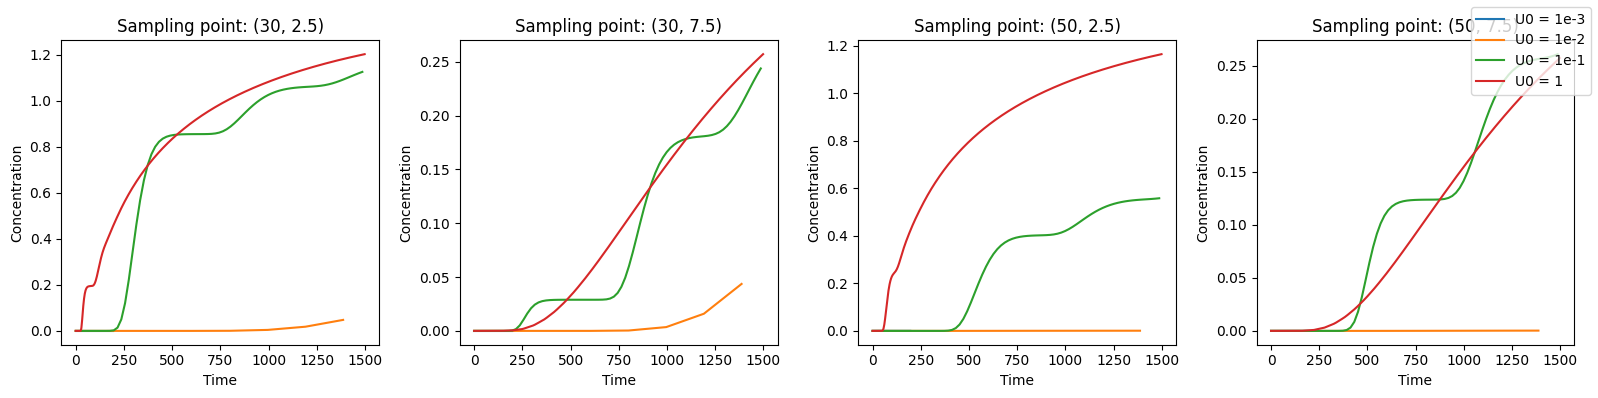

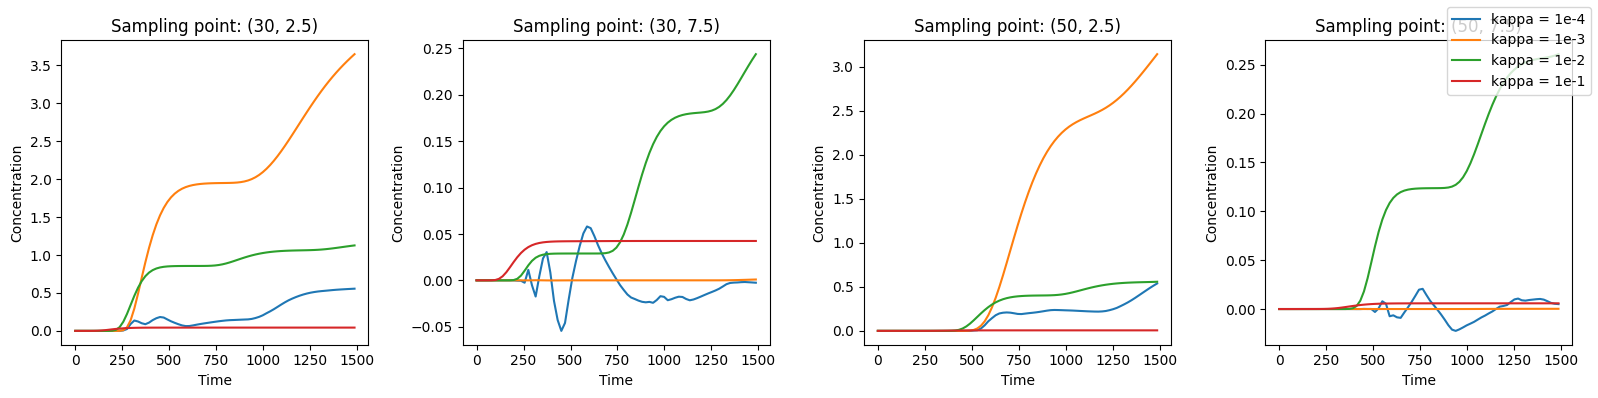

In [1]:
"""
Script to solve the time-dependent advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

def time_dependent_advection_diffusion(U0, kappa, x_sample, y_sample):
  # Set parameters
  w = 10 # width of the river in m
  L = 50 # length of the river section to simulate
  S0 = 1 # amplitude of the pollution source term
  S_w = 1 # width of the source term in m
  S_x = 10 # center of the forcing in x
  S_y = 0 # center of the forcing in y
  S_t = 1 # forcing timescale

  # Numerical parameters
  Nx = 256 # number of gridoints in x
  Ny = 32 # number of gridpoints in y
  stop_sim_time=1500 # end time in seconds
  timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

  # Bases and coordinates
  coords = dedalus.CartesianCoordinates('x', 'y')
  dist = dedalus.Distributor(coords, dtype=np.float64)
  xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
  ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
  x, y = dist.local_grids(xbasis, ybasis)
  ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

  # Fields
  c = dist.Field(name='b', bases=(xbasis,ybasis))
  u = dist.Field(name='u', bases=(xbasis,ybasis))
  tau_1 = dist.Field(name='tau_1', bases=xbasis)
  tau_2 = dist.Field(name='tau_2', bases=xbasis)

  # Specify the velocity field
  u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

  # Substitutions
  lift_basis = ybasis.derivative_basis(1)
  lift = lambda A: dedalus.Lift(A, lift_basis, -1)
  grad_c = dedalus.grad(c) + ey*lift(tau_1)
  dx = lambda A: dedalus.Differentiate(A, coords['x'])

  S = dist.Field(name='u', bases=(xbasis,ybasis))
  S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

  # Problem
  problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
  problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
  problem.add_equation("c(y=0) = 0")
  problem.add_equation("c(y=w) = 0")

  # Now, set the solver
  solver = problem.build_solver(dedalus.RK222)
  solver.stop_sim_time = stop_sim_time

  # Create an array to periodically save the concentration field for plotting later
  c.change_scales(1)
  c_save = [np.copy(c['g'])];

  t_save = [solver.sim_time]; # Save the initial condition and the initial time
  # Main loop
  try:
      logger.info('Starting main loop')
      while solver.proceed:
          solver.step(timestep)
          if (solver.iteration-1) % 10 == 0:
              #logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
              c.change_scales(1)
              c_save.append(np.copy(c['g']))
              t_save.append(solver.sim_time)
  except:
      logger.error('Exception raised, triggering end of main loop.')
      raise
  finally:
      solver.log_stats()

  # Convert the variables to numpy arrays for allow array slicing
  c_save = np.array(c_save)
  t_save = np.array(t_save)

  x_index = np.argmin(np.abs(x-x_sample))
  y_index = np.argmin(np.abs(y-y_sample))
  c_sample = c_save[:,x_index,y_index]

  return c_sample, t_save

# Specify sampling points
sampling_points = [(30, 2.5), (30,7.5), (50,2.5), (50,7.5)]

# Varying U0 with kappa constnat
U0_values = [1e-3, 1e-2, 1e-1, 1]
kappa = 1e-2

fig1, ax1 = plt.subplots(1,4, figsize=(16,4))
for i in range(len(sampling_points)):
  x_sample, y_sample = sampling_points[i]
  for j in range(len(U0_values)):
    U0 = U0_values[j]
    c_sample, t_save = time_dependent_advection_diffusion(U0, kappa, x_sample, y_sample)
    ax1[i].plot(t_save, c_sample)
  ax1[i].set_xlabel('Time')
  ax1[i].set_ylabel('Concentration')
  ax1[i].set_title(f'Sampling point: ({x_sample}, {y_sample})')
fig1.legend(['U0 = 1e-3', 'U0 = 1e-2', 'U0 = 1e-1', 'U0 = 1'])
fig1.tight_layout()


# Varying kappa with U0 constant
U0 = 0.1
kappa_values = [1e-4, 1e-3, 1e-2, 1e-1]

fig2, ax2 = plt.subplots(1,4, figsize=(16,4))
for i in range(len(sampling_points)):
  x_sample, y_sample = sampling_points[i]
  for j in range(len(kappa_values)):
    kappa = kappa_values[j]
    c_sample, t_save = time_dependent_advection_diffusion(U0, kappa, x_sample, y_sample)
    ax2[i].plot(t_save, c_sample)
  ax2[i].set_xlabel('Time')
  ax2[i].set_ylabel('Concentration')
  ax2[i].set_title(f'Sampling point: ({x_sample}, {y_sample})')
fig2.legend(['kappa = 1e-4', 'kappa = 1e-3', 'kappa = 1e-2', 'kappa = 1e-1'])
fig2.tight_layout()

## 3. Optional further investigations

* In the river pollution example, you might notice that the concentration field is mixed more effectively in the x-direction than in the y-direction. The combination of differential advection by the currents and cross-stream diffusion is very effective at mixing the plume in the x-direction. This is an example of Taylor dispersion (Taylor, 1953). Construct numerical experiments to quantify Taylor dispersion and its dependence on the current shear and the diffusivity. You could also separate the diffusivity into parts in the x and y directions with different coefficients.  If you set the x-component of the diffusivity to zero, then any spreading of the concentration in the x-direction should be due to Taylor dispersion.

* Try making the river speed a function of time. The easiest way to do this is to add a new equation so that Dedalus solves for the velocity in addition to the concentration field. For example, you could make the river speed decrease exponentially in time, or it could be sinusoidal in time.

* In the ocean mixing example, if $\kappa$ is a function of $x$ and $z$, what would this imply about the velocity field? You could even try writing a Dedalus script to solve the 2D advection/diffusion equation with a prescribed spatially-dependent $\kappa(x,z)$.


### References

Munk, W.H., 1966. Abyssal recipes. In Deep sea research and oceanographic abstracts (Vol. 13, No. 4, pp. 707-730). Elsevier.

Ferrari, R., Mashayek, A., McDougall, T.J., Nikurashin, M. and Campin, J.M., 2016. Turning ocean mixing upside down. Journal of Physical Oceanography, 46(7), pp.2239-2261.

Taylor, G.I., 1953. Dispersion of soluble matter in solvent flowing slowly through a tube. Proceedings of the Royal Society of London. Series A. Mathematical and Physical Sciences, 219(1137), pp.186-203.